In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'VTCNN2V2'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(165000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.rml201610a_VTCNN2_v2(in_shp)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 1, 6, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 2, 256)         33024     
_________________________________________________________________
dropout (Dropout)            (None, 1, 2, 256)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 6, 256)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 2, 80)          82000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 2, 80)          0

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/162 [..............................] - ETA: 30:50 - loss: 2.3977

  8/162 [>.............................] - ETA: 1s - loss: 2.3977   

 16/162 [=>............................] - ETA: 1s - loss: 2.3973

 24/162 [===>..........................] - ETA: 0s - loss: 2.3966

 32/162 [====>.........................] - ETA: 0s - loss: 2.3951

 40/162 [======>.......................] - ETA: 0s - loss: 2.3919

 49/162 [========>.....................] - ETA: 0s - loss: 2.3863

 57/162 [=========>....................] - ETA: 0s - loss: 2.3804

 65/162 [===========>..................] - ETA: 0s - loss: 2.3744

 74/162 [============>.................] - ETA: 0s - loss: 2.3680

 83/162 [==============>...............] - ETA: 0s - loss: 2.3620

 91/162 [===============>..............] - ETA: 0s - loss: 2.3571

100/162 [=================>............] - ETA: 0s - loss: 2.3520

109/162 [===================>..........] - ETA: 0s - loss: 2.3473

118/162 [====================>.........] - ETA: 0s - loss: 2.3429

127/162 [======================>.......] - ETA: 0s - loss: 2.3388

135/162 [========================>.....] - ETA: 0s - loss: 2.3355

143/162 [=========================>....] - ETA: 0s - loss: 2.3323

152/162 [===========================>..] - ETA: 0s - loss: 2.3289

161/162 [============================>.] - ETA: 0s - loss: 2.3258

162/162 [==============================] - 13s 10ms/step - loss: 2.3251 - val_loss: 2.1997


Epoch 2/100
  1/162 [..............................] - ETA: 1s - loss: 2.2319

  9/162 [>.............................] - ETA: 0s - loss: 2.2229

 18/162 [==>...........................] - ETA: 0s - loss: 2.2159

 27/162 [====>.........................] - ETA: 0s - loss: 2.2116

 36/162 [=====>........................] - ETA: 0s - loss: 2.2080

 44/162 [=======>......................] - ETA: 0s - loss: 2.2046

 53/162 [========>.....................] - ETA: 0s - loss: 2.2010

 62/162 [==========>...................] - ETA: 0s - loss: 2.1973

 71/162 [============>.................] - ETA: 0s - loss: 2.1936

 80/162 [=============>................] - ETA: 0s - loss: 2.1898

 89/162 [===============>..............] - ETA: 0s - loss: 2.1858

 98/162 [=================>............] - ETA: 0s - loss: 2.1818

107/162 [==================>...........] - ETA: 0s - loss: 2.1778

116/162 [====================>.........] - ETA: 0s - loss: 2.1738

125/162 [======================>.......] - ETA: 0s - loss: 2.1700

133/162 [=======================>......] - ETA: 0s - loss: 2.1666

141/162 [=========================>....] - ETA: 0s - loss: 2.1634

150/162 [==========================>...] - ETA: 0s - loss: 2.1598

159/162 [============================>.] - ETA: 0s - loss: 2.1564

162/162 [==============================] - 1s 7ms/step - loss: 2.1549 - val_loss: 1.9553


Epoch 3/100


  1/162 [..............................] - ETA: 1s - loss: 2.0359

 10/162 [>.............................] - ETA: 0s - loss: 2.0163

 19/162 [==>...........................] - ETA: 0s - loss: 2.0137

 27/162 [====>.........................] - ETA: 0s - loss: 2.0124

 36/162 [=====>........................] - ETA: 0s - loss: 2.0107

 45/162 [=======>......................] - ETA: 0s - loss: 2.0087

 54/162 [=========>....................] - ETA: 0s - loss: 2.0067

 63/162 [==========>...................] - ETA: 0s - loss: 2.0048

 72/162 [============>.................] - ETA: 0s - loss: 2.0034

 81/162 [==============>...............] - ETA: 0s - loss: 2.0021

 89/162 [===============>..............] - ETA: 0s - loss: 2.0010

 98/162 [=================>............] - ETA: 0s - loss: 1.9999

107/162 [==================>...........] - ETA: 0s - loss: 1.9988

115/162 [====================>.........] - ETA: 0s - loss: 1.9978

124/162 [=====================>........] - ETA: 0s - loss: 1.9967

132/162 [=======================>......] - ETA: 0s - loss: 1.9958

141/162 [=========================>....] - ETA: 0s - loss: 1.9948

149/162 [==========================>...] - ETA: 0s - loss: 1.9939

158/162 [============================>.] - ETA: 0s - loss: 1.9930

162/162 [==============================] - 1s 7ms/step - loss: 1.9925 - val_loss: 1.8900


Epoch 4/100
  1/162 [..............................] - ETA: 1s - loss: 1.9631

 10/162 [>.............................] - ETA: 0s - loss: 1.9548

 19/162 [==>...........................] - ETA: 0s - loss: 1.9539

 28/162 [====>.........................] - ETA: 0s - loss: 1.9517

 37/162 [=====>........................] - ETA: 0s - loss: 1.9503

 45/162 [=======>......................] - ETA: 0s - loss: 1.9490

 54/162 [=========>....................] - ETA: 0s - loss: 1.9477

 62/162 [==========>...................] - ETA: 0s - loss: 1.9466

 71/162 [============>.................] - ETA: 0s - loss: 1.9453

 79/162 [=============>................] - ETA: 0s - loss: 1.9442

 87/162 [===============>..............] - ETA: 0s - loss: 1.9431

 96/162 [================>.............] - ETA: 0s - loss: 1.9420

105/162 [==================>...........] - ETA: 0s - loss: 1.9411

113/162 [===================>..........] - ETA: 0s - loss: 1.9404

121/162 [=====================>........] - ETA: 0s - loss: 1.9396

130/162 [=======================>......] - ETA: 0s - loss: 1.9388

139/162 [========================>.....] - ETA: 0s - loss: 1.9381

147/162 [==========================>...] - ETA: 0s - loss: 1.9374

155/162 [===========================>..] - ETA: 0s - loss: 1.9367

162/162 [==============================] - 1s 7ms/step - loss: 1.9360 - val_loss: 1.8238


Epoch 5/100
  1/162 [..............................] - ETA: 1s - loss: 1.9204

 10/162 [>.............................] - ETA: 0s - loss: 1.8945

 19/162 [==>...........................] - ETA: 0s - loss: 1.8968

 28/162 [====>.........................] - ETA: 0s - loss: 1.8973

 37/162 [=====>........................] - ETA: 0s - loss: 1.8969

 46/162 [=======>......................] - ETA: 0s - loss: 1.8959

 55/162 [=========>....................] - ETA: 0s - loss: 1.8949

 64/162 [==========>...................] - ETA: 0s - loss: 1.8942

 73/162 [============>.................] - ETA: 0s - loss: 1.8936

 82/162 [==============>...............] - ETA: 0s - loss: 1.8930

 90/162 [===============>..............] - ETA: 0s - loss: 1.8924

 98/162 [=================>............] - ETA: 0s - loss: 1.8920

106/162 [==================>...........] - ETA: 0s - loss: 1.8916

115/162 [====================>.........] - ETA: 0s - loss: 1.8912

123/162 [=====================>........] - ETA: 0s - loss: 1.8909

132/162 [=======================>......] - ETA: 0s - loss: 1.8905

140/162 [========================>.....] - ETA: 0s - loss: 1.8901

149/162 [==========================>...] - ETA: 0s - loss: 1.8897

157/162 [============================>.] - ETA: 0s - loss: 1.8895

162/162 [==============================] - 1s 7ms/step - loss: 1.8893 - val_loss: 1.7955


Epoch 6/100
  1/162 [..............................] - ETA: 1s - loss: 1.9260

  9/162 [>.............................] - ETA: 1s - loss: 1.8970

 17/162 [==>...........................] - ETA: 0s - loss: 1.8852

 25/162 [===>..........................] - ETA: 0s - loss: 1.8798

 34/162 [=====>........................] - ETA: 0s - loss: 1.8771

 43/162 [======>.......................] - ETA: 0s - loss: 1.8752

 52/162 [========>.....................] - ETA: 0s - loss: 1.8738

 61/162 [==========>...................] - ETA: 0s - loss: 1.8725

 70/162 [===========>..................] - ETA: 0s - loss: 1.8714

 79/162 [=============>................] - ETA: 0s - loss: 1.8704

 88/162 [===============>..............] - ETA: 0s - loss: 1.8696

 97/162 [================>.............] - ETA: 0s - loss: 1.8688

106/162 [==================>...........] - ETA: 0s - loss: 1.8680

115/162 [====================>.........] - ETA: 0s - loss: 1.8674

124/162 [=====================>........] - ETA: 0s - loss: 1.8669

133/162 [=======================>......] - ETA: 0s - loss: 1.8665

142/162 [=========================>....] - ETA: 0s - loss: 1.8661

151/162 [==========================>...] - ETA: 0s - loss: 1.8658

160/162 [============================>.] - ETA: 0s - loss: 1.8656

162/162 [==============================] - 1s 7ms/step - loss: 1.8655 - val_loss: 1.7773


Epoch 7/100


  1/162 [..............................] - ETA: 1s - loss: 1.8305

 10/162 [>.............................] - ETA: 0s - loss: 1.8502

 19/162 [==>...........................] - ETA: 0s - loss: 1.8513

 28/162 [====>.........................] - ETA: 0s - loss: 1.8501

 36/162 [=====>........................] - ETA: 0s - loss: 1.8493

 45/162 [=======>......................] - ETA: 0s - loss: 1.8488

 54/162 [=========>....................] - ETA: 0s - loss: 1.8484

 63/162 [==========>...................] - ETA: 0s - loss: 1.8483

 71/162 [============>.................] - ETA: 0s - loss: 1.8480

 80/162 [=============>................] - ETA: 0s - loss: 1.8477

 88/162 [===============>..............] - ETA: 0s - loss: 1.8475

 97/162 [================>.............] - ETA: 0s - loss: 1.8474

106/162 [==================>...........] - ETA: 0s - loss: 1.8472

114/162 [====================>.........] - ETA: 0s - loss: 1.8472

123/162 [=====================>........] - ETA: 0s - loss: 1.8471

132/162 [=======================>......] - ETA: 0s - loss: 1.8470

141/162 [=========================>....] - ETA: 0s - loss: 1.8469

150/162 [==========================>...] - ETA: 0s - loss: 1.8468

159/162 [============================>.] - ETA: 0s - loss: 1.8467

162/162 [==============================] - 1s 7ms/step - loss: 1.8467 - val_loss: 1.7674


Epoch 8/100
  1/162 [..............................] - ETA: 1s - loss: 1.8096

 10/162 [>.............................] - ETA: 0s - loss: 1.8308

 19/162 [==>...........................] - ETA: 0s - loss: 1.8317

 28/162 [====>.........................] - ETA: 0s - loss: 1.8324

 37/162 [=====>........................] - ETA: 0s - loss: 1.8334

 46/162 [=======>......................] - ETA: 0s - loss: 1.8337

 55/162 [=========>....................] - ETA: 0s - loss: 1.8342

 64/162 [==========>...................] - ETA: 0s - loss: 1.8346

 73/162 [============>.................] - ETA: 0s - loss: 1.8350

 82/162 [==============>...............] - ETA: 0s - loss: 1.8354

 91/162 [===============>..............] - ETA: 0s - loss: 1.8355

100/162 [=================>............] - ETA: 0s - loss: 1.8357

109/162 [===================>..........] - ETA: 0s - loss: 1.8357

118/162 [====================>.........] - ETA: 0s - loss: 1.8358

127/162 [======================>.......] - ETA: 0s - loss: 1.8358

135/162 [========================>.....] - ETA: 0s - loss: 1.8359

143/162 [=========================>....] - ETA: 0s - loss: 1.8359

151/162 [==========================>...] - ETA: 0s - loss: 1.8358

160/162 [============================>.] - ETA: 0s - loss: 1.8358

162/162 [==============================] - 1s 7ms/step - loss: 1.8357 - val_loss: 1.7540


Epoch 9/100
  1/162 [..............................] - ETA: 1s - loss: 1.8309

  9/162 [>.............................] - ETA: 0s - loss: 1.8348

 18/162 [==>...........................] - ETA: 0s - loss: 1.8344

 27/162 [====>.........................] - ETA: 0s - loss: 1.8330

 36/162 [=====>........................] - ETA: 0s - loss: 1.8322

 45/162 [=======>......................] - ETA: 0s - loss: 1.8311

 54/162 [=========>....................] - ETA: 0s - loss: 1.8303

 63/162 [==========>...................] - ETA: 0s - loss: 1.8295

 72/162 [============>.................] - ETA: 0s - loss: 1.8289

 81/162 [==============>...............] - ETA: 0s - loss: 1.8283

 90/162 [===============>..............] - ETA: 0s - loss: 1.8279

 99/162 [=================>............] - ETA: 0s - loss: 1.8276

107/162 [==================>...........] - ETA: 0s - loss: 1.8273

115/162 [====================>.........] - ETA: 0s - loss: 1.8270

123/162 [=====================>........] - ETA: 0s - loss: 1.8269

131/162 [=======================>......] - ETA: 0s - loss: 1.8267

139/162 [========================>.....] - ETA: 0s - loss: 1.8266

148/162 [==========================>...] - ETA: 0s - loss: 1.8263

157/162 [============================>.] - ETA: 0s - loss: 1.8261

162/162 [==============================] - 1s 7ms/step - loss: 1.8260 - val_loss: 1.7451


Epoch 10/100
  1/162 [..............................] - ETA: 1s - loss: 1.8549

  9/162 [>.............................] - ETA: 0s - loss: 1.8411

 17/162 [==>...........................] - ETA: 0s - loss: 1.8335

 25/162 [===>..........................] - ETA: 0s - loss: 1.8302

 33/162 [=====>........................] - ETA: 0s - loss: 1.8288



 41/162 [======>.......................] - ETA: 0s - loss: 1.8279

 49/162 [========>.....................] - ETA: 0s - loss: 1.8270

 58/162 [=========>....................] - ETA: 0s - loss: 1.8259

 67/162 [===========>..................] - ETA: 0s - loss: 1.8249

 75/162 [============>.................] - ETA: 0s - loss: 1.8242

 83/162 [==============>...............] - ETA: 0s - loss: 1.8237

 92/162 [================>.............] - ETA: 0s - loss: 1.8231

101/162 [=================>............] - ETA: 0s - loss: 1.8225

109/162 [===================>..........] - ETA: 0s - loss: 1.8220

117/162 [====================>.........] - ETA: 0s - loss: 1.8216

125/162 [======================>.......] - ETA: 0s - loss: 1.8212

134/162 [=======================>......] - ETA: 0s - loss: 1.8208

142/162 [=========================>....] - ETA: 0s - loss: 1.8205

151/162 [==========================>...] - ETA: 0s - loss: 1.8203

159/162 [============================>.] - ETA: 0s - loss: 1.8200

162/162 [==============================] - 1s 7ms/step - loss: 1.8199 - val_loss: 1.7381


Epoch 11/100
  1/162 [..............................] - ETA: 1s - loss: 1.7838

  9/162 [>.............................] - ETA: 0s - loss: 1.8025

 17/162 [==>...........................] - ETA: 0s - loss: 1.8045

 25/162 [===>..........................] - ETA: 0s - loss: 1.8056

 33/162 [=====>........................] - ETA: 0s - loss: 1.8064



 41/162 [======>.......................] - ETA: 0s - loss: 1.8072

 49/162 [========>.....................] - ETA: 0s - loss: 1.8074

 57/162 [=========>....................] - ETA: 0s - loss: 1.8077

 65/162 [===========>..................] - ETA: 0s - loss: 1.8080

 74/162 [============>.................] - ETA: 0s - loss: 1.8083

 83/162 [==============>...............] - ETA: 0s - loss: 1.8084

 91/162 [===============>..............] - ETA: 0s - loss: 1.8084

100/162 [=================>............] - ETA: 0s - loss: 1.8085

109/162 [===================>..........] - ETA: 0s - loss: 1.8085

118/162 [====================>.........] - ETA: 0s - loss: 1.8085

126/162 [======================>.......] - ETA: 0s - loss: 1.8084

135/162 [========================>.....] - ETA: 0s - loss: 1.8083

143/162 [=========================>....] - ETA: 0s - loss: 1.8083

151/162 [==========================>...] - ETA: 0s - loss: 1.8082

160/162 [============================>.] - ETA: 0s - loss: 1.8082

162/162 [==============================] - 1s 7ms/step - loss: 1.8082 - val_loss: 1.7344


Epoch 12/100
  1/162 [..............................] - ETA: 1s - loss: 1.8050

 10/162 [>.............................] - ETA: 0s - loss: 1.7993



 18/162 [==>...........................] - ETA: 0s - loss: 1.8022

 26/162 [===>..........................] - ETA: 0s - loss: 1.8025

 34/162 [=====>........................] - ETA: 0s - loss: 1.8026

 42/162 [======>.......................] - ETA: 0s - loss: 1.8028

 50/162 [========>.....................] - ETA: 0s - loss: 1.8031

 58/162 [=========>....................] - ETA: 0s - loss: 1.8033

 66/162 [===========>..................] - ETA: 0s - loss: 1.8033

 74/162 [============>.................] - ETA: 0s - loss: 1.8034

 82/162 [==============>...............] - ETA: 0s - loss: 1.8035

 91/162 [===============>..............] - ETA: 0s - loss: 1.8035

 99/162 [=================>............] - ETA: 0s - loss: 1.8036

107/162 [==================>...........] - ETA: 0s - loss: 1.8036

115/162 [====================>.........] - ETA: 0s - loss: 1.8037

123/162 [=====================>........] - ETA: 0s - loss: 1.8037

131/162 [=======================>......] - ETA: 0s - loss: 1.8037

139/162 [========================>.....] - ETA: 0s - loss: 1.8037



147/162 [==========================>...] - ETA: 0s - loss: 1.8038



155/162 [===========================>..] - ETA: 0s - loss: 1.8038

162/162 [==============================] - 1s 7ms/step - loss: 1.8037 - val_loss: 1.7325


Epoch 13/100
  1/162 [..............................] - ETA: 1s - loss: 1.7890

  9/162 [>.............................] - ETA: 1s - loss: 1.8008



 17/162 [==>...........................] - ETA: 0s - loss: 1.7999

 25/162 [===>..........................] - ETA: 0s - loss: 1.7988

 33/162 [=====>........................] - ETA: 0s - loss: 1.7984

 42/162 [======>.......................] - ETA: 0s - loss: 1.7986

 50/162 [========>.....................] - ETA: 0s - loss: 1.7984

 58/162 [=========>....................] - ETA: 0s - loss: 1.7982

 66/162 [===========>..................] - ETA: 0s - loss: 1.7982

 74/162 [============>.................] - ETA: 0s - loss: 1.7983

 82/162 [==============>...............] - ETA: 0s - loss: 1.7983

 90/162 [===============>..............] - ETA: 0s - loss: 1.7983

 99/162 [=================>............] - ETA: 0s - loss: 1.7983

107/162 [==================>...........] - ETA: 0s - loss: 1.7984

115/162 [====================>.........] - ETA: 0s - loss: 1.7985



124/162 [=====================>........] - ETA: 0s - loss: 1.7985

132/162 [=======================>......] - ETA: 0s - loss: 1.7985

140/162 [========================>.....] - ETA: 0s - loss: 1.7985

148/162 [==========================>...] - ETA: 0s - loss: 1.7985

156/162 [===========================>..] - ETA: 0s - loss: 1.7985

162/162 [==============================] - 1s 7ms/step - loss: 1.7985 - val_loss: 1.7313


Epoch 14/100
  1/162 [..............................] - ETA: 1s - loss: 1.8541

  9/162 [>.............................] - ETA: 0s - loss: 1.7943

 18/162 [==>...........................] - ETA: 0s - loss: 1.7900

 27/162 [====>.........................] - ETA: 0s - loss: 1.7896

 35/162 [=====>........................] - ETA: 0s - loss: 1.7902

 44/162 [=======>......................] - ETA: 0s - loss: 1.7907

 53/162 [========>.....................] - ETA: 0s - loss: 1.7915

 61/162 [==========>...................] - ETA: 0s - loss: 1.7921

 70/162 [===========>..................] - ETA: 0s - loss: 1.7925

 79/162 [=============>................] - ETA: 0s - loss: 1.7926

 88/162 [===============>..............] - ETA: 0s - loss: 1.7927

 97/162 [================>.............] - ETA: 0s - loss: 1.7927

106/162 [==================>...........] - ETA: 0s - loss: 1.7926

114/162 [====================>.........] - ETA: 0s - loss: 1.7926

122/162 [=====================>........] - ETA: 0s - loss: 1.7925

130/162 [=======================>......] - ETA: 0s - loss: 1.7924

139/162 [========================>.....] - ETA: 0s - loss: 1.7924

148/162 [==========================>...] - ETA: 0s - loss: 1.7924

157/162 [============================>.] - ETA: 0s - loss: 1.7924

162/162 [==============================] - 1s 7ms/step - loss: 1.7924 - val_loss: 1.7307


Epoch 15/100
  1/162 [..............................] - ETA: 1s - loss: 1.7814

  9/162 [>.............................] - ETA: 0s - loss: 1.7784

 18/162 [==>...........................] - ETA: 0s - loss: 1.7799

 27/162 [====>.........................] - ETA: 0s - loss: 1.7815

 35/162 [=====>........................] - ETA: 0s - loss: 1.7826

 44/162 [=======>......................] - ETA: 0s - loss: 1.7836

 53/162 [========>.....................] - ETA: 0s - loss: 1.7842

 62/162 [==========>...................] - ETA: 0s - loss: 1.7848

 70/162 [===========>..................] - ETA: 0s - loss: 1.7852

 78/162 [=============>................] - ETA: 0s - loss: 1.7855

 87/162 [===============>..............] - ETA: 0s - loss: 1.7858

 95/162 [================>.............] - ETA: 0s - loss: 1.7860

104/162 [==================>...........] - ETA: 0s - loss: 1.7861

113/162 [===================>..........] - ETA: 0s - loss: 1.7861

122/162 [=====================>........] - ETA: 0s - loss: 1.7862

131/162 [=======================>......] - ETA: 0s - loss: 1.7863

139/162 [========================>.....] - ETA: 0s - loss: 1.7864

148/162 [==========================>...] - ETA: 0s - loss: 1.7865

157/162 [============================>.] - ETA: 0s - loss: 1.7866

162/162 [==============================] - 1s 7ms/step - loss: 1.7867 - val_loss: 1.7247


Epoch 16/100
  1/162 [..............................] - ETA: 2s - loss: 1.7417

  8/162 [>.............................] - ETA: 1s - loss: 1.7747

 17/162 [==>...........................] - ETA: 0s - loss: 1.7772

 26/162 [===>..........................] - ETA: 0s - loss: 1.7787

 35/162 [=====>........................] - ETA: 0s - loss: 1.7792

 44/162 [=======>......................] - ETA: 0s - loss: 1.7797

 52/162 [========>.....................] - ETA: 0s - loss: 1.7801

 61/162 [==========>...................] - ETA: 0s - loss: 1.7805

 69/162 [===========>..................] - ETA: 0s - loss: 1.7809

 78/162 [=============>................] - ETA: 0s - loss: 1.7812

 87/162 [===============>..............] - ETA: 0s - loss: 1.7815

 96/162 [================>.............] - ETA: 0s - loss: 1.7818

105/162 [==================>...........] - ETA: 0s - loss: 1.7820

114/162 [====================>.........] - ETA: 0s - loss: 1.7822

123/162 [=====================>........] - ETA: 0s - loss: 1.7823

131/162 [=======================>......] - ETA: 0s - loss: 1.7825

140/162 [========================>.....] - ETA: 0s - loss: 1.7826

149/162 [==========================>...] - ETA: 0s - loss: 1.7828

158/162 [============================>.] - ETA: 0s - loss: 1.7829

162/162 [==============================] - 1s 7ms/step - loss: 1.7830 - val_loss: 1.7182


Epoch 17/100
  1/162 [..............................] - ETA: 0s - loss: 1.7972

 10/162 [>.............................] - ETA: 0s - loss: 1.7875

 18/162 [==>...........................] - ETA: 0s - loss: 1.7870

 26/162 [===>..........................] - ETA: 0s - loss: 1.7860

 35/162 [=====>........................] - ETA: 0s - loss: 1.7855

 43/162 [======>.......................] - ETA: 0s - loss: 1.7848

 52/162 [========>.....................] - ETA: 0s - loss: 1.7842

 60/162 [==========>...................] - ETA: 0s - loss: 1.7842

 69/162 [===========>..................] - ETA: 0s - loss: 1.7840

 77/162 [=============>................] - ETA: 0s - loss: 1.7838

 86/162 [==============>...............] - ETA: 0s - loss: 1.7837

 95/162 [================>.............] - ETA: 0s - loss: 1.7836

104/162 [==================>...........] - ETA: 0s - loss: 1.7836

113/162 [===================>..........] - ETA: 0s - loss: 1.7837

122/162 [=====================>........] - ETA: 0s - loss: 1.7837

131/162 [=======================>......] - ETA: 0s - loss: 1.7837

139/162 [========================>.....] - ETA: 0s - loss: 1.7836

147/162 [==========================>...] - ETA: 0s - loss: 1.7835

156/162 [===========================>..] - ETA: 0s - loss: 1.7834

162/162 [==============================] - 1s 7ms/step - loss: 1.7834 - val_loss: 1.7186


Epoch 18/100
  1/162 [..............................] - ETA: 1s - loss: 1.8021

  9/162 [>.............................] - ETA: 0s - loss: 1.7843

 18/162 [==>...........................] - ETA: 0s - loss: 1.7825

 27/162 [====>.........................] - ETA: 0s - loss: 1.7815

 36/162 [=====>........................] - ETA: 0s - loss: 1.7807

 45/162 [=======>......................] - ETA: 0s - loss: 1.7796

 54/162 [=========>....................] - ETA: 0s - loss: 1.7788

 63/162 [==========>...................] - ETA: 0s - loss: 1.7783

 72/162 [============>.................] - ETA: 0s - loss: 1.7779

 81/162 [==============>...............] - ETA: 0s - loss: 1.7776

 90/162 [===============>..............] - ETA: 0s - loss: 1.7772

 99/162 [=================>............] - ETA: 0s - loss: 1.7770

108/162 [===================>..........] - ETA: 0s - loss: 1.7768

117/162 [====================>.........] - ETA: 0s - loss: 1.7767

126/162 [======================>.......] - ETA: 0s - loss: 1.7766

135/162 [========================>.....] - ETA: 0s - loss: 1.7766

143/162 [=========================>....] - ETA: 0s - loss: 1.7766

151/162 [==========================>...] - ETA: 0s - loss: 1.7766

159/162 [============================>.] - ETA: 0s - loss: 1.7766

162/162 [==============================] - 1s 7ms/step - loss: 1.7766 - val_loss: 1.7126


Epoch 19/100


  1/162 [..............................] - ETA: 1s - loss: 1.7392

 10/162 [>.............................] - ETA: 0s - loss: 1.7704

 19/162 [==>...........................] - ETA: 0s - loss: 1.7746

 28/162 [====>.........................] - ETA: 0s - loss: 1.7759

 36/162 [=====>........................] - ETA: 0s - loss: 1.7754

 45/162 [=======>......................] - ETA: 0s - loss: 1.7757

 54/162 [=========>....................] - ETA: 0s - loss: 1.7758



 62/162 [==========>...................] - ETA: 0s - loss: 1.7756

 70/162 [===========>..................] - ETA: 0s - loss: 1.7755

 78/162 [=============>................] - ETA: 0s - loss: 1.7752

 86/162 [==============>...............] - ETA: 0s - loss: 1.7751

 94/162 [================>.............] - ETA: 0s - loss: 1.7750

102/162 [=================>............] - ETA: 0s - loss: 1.7749

110/162 [===================>..........] - ETA: 0s - loss: 1.7750

119/162 [=====================>........] - ETA: 0s - loss: 1.7751

127/162 [======================>.......] - ETA: 0s - loss: 1.7752

135/162 [========================>.....] - ETA: 0s - loss: 1.7753

143/162 [=========================>....] - ETA: 0s - loss: 1.7753

151/162 [==========================>...] - ETA: 0s - loss: 1.7753

159/162 [============================>.] - ETA: 0s - loss: 1.7753

162/162 [==============================] - 1s 7ms/step - loss: 1.7753 - val_loss: 1.7170


Epoch 20/100
  1/162 [..............................] - ETA: 1s - loss: 1.7820

 10/162 [>.............................] - ETA: 0s - loss: 1.7638

 19/162 [==>...........................] - ETA: 0s - loss: 1.7647

 27/162 [====>.........................] - ETA: 0s - loss: 1.7658

 35/162 [=====>........................] - ETA: 0s - loss: 1.7668

 43/162 [======>.......................] - ETA: 0s - loss: 1.7677

 52/162 [========>.....................] - ETA: 0s - loss: 1.7683

 60/162 [==========>...................] - ETA: 0s - loss: 1.7687

 69/162 [===========>..................] - ETA: 0s - loss: 1.7691

 78/162 [=============>................] - ETA: 0s - loss: 1.7693

 86/162 [==============>...............] - ETA: 0s - loss: 1.7694

 94/162 [================>.............] - ETA: 0s - loss: 1.7695

103/162 [==================>...........] - ETA: 0s - loss: 1.7696

112/162 [===================>..........] - ETA: 0s - loss: 1.7698

121/162 [=====================>........] - ETA: 0s - loss: 1.7700

130/162 [=======================>......] - ETA: 0s - loss: 1.7701

139/162 [========================>.....] - ETA: 0s - loss: 1.7703



148/162 [==========================>...] - ETA: 0s - loss: 1.7704

157/162 [============================>.] - ETA: 0s - loss: 1.7705

162/162 [==============================] - 1s 7ms/step - loss: 1.7706 - val_loss: 1.7140


Epoch 21/100
  1/162 [..............................] - ETA: 0s - loss: 1.7873

 10/162 [>.............................] - ETA: 0s - loss: 1.7799

 19/162 [==>...........................] - ETA: 0s - loss: 1.7786

 28/162 [====>.........................] - ETA: 0s - loss: 1.7776

 37/162 [=====>........................] - ETA: 0s - loss: 1.7771

 45/162 [=======>......................] - ETA: 0s - loss: 1.7765

 54/162 [=========>....................] - ETA: 0s - loss: 1.7759

 63/162 [==========>...................] - ETA: 0s - loss: 1.7755

 72/162 [============>.................] - ETA: 0s - loss: 1.7751

 81/162 [==============>...............] - ETA: 0s - loss: 1.7747

 89/162 [===============>..............] - ETA: 0s - loss: 1.7743

 98/162 [=================>............] - ETA: 0s - loss: 1.7741

107/162 [==================>...........] - ETA: 0s - loss: 1.7739

116/162 [====================>.........] - ETA: 0s - loss: 1.7736

125/162 [======================>.......] - ETA: 0s - loss: 1.7735

134/162 [=======================>......] - ETA: 0s - loss: 1.7733

143/162 [=========================>....] - ETA: 0s - loss: 1.7731

152/162 [===========================>..] - ETA: 0s - loss: 1.7730

161/162 [============================>.] - ETA: 0s - loss: 1.7728

162/162 [==============================] - 1s 7ms/step - loss: 1.7728 - val_loss: 1.7061


Epoch 22/100
  1/162 [..............................] - ETA: 0s - loss: 1.7904

 10/162 [>.............................] - ETA: 0s - loss: 1.7791

 18/162 [==>...........................] - ETA: 0s - loss: 1.7779

 26/162 [===>..........................] - ETA: 0s - loss: 1.7763

 35/162 [=====>........................] - ETA: 0s - loss: 1.7751

 44/162 [=======>......................] - ETA: 0s - loss: 1.7741

 52/162 [========>.....................] - ETA: 0s - loss: 1.7734

 61/162 [==========>...................] - ETA: 0s - loss: 1.7727

 70/162 [===========>..................] - ETA: 0s - loss: 1.7723

 79/162 [=============>................] - ETA: 0s - loss: 1.7720

 88/162 [===============>..............] - ETA: 0s - loss: 1.7717

 97/162 [================>.............] - ETA: 0s - loss: 1.7715

105/162 [==================>...........] - ETA: 0s - loss: 1.7712

114/162 [====================>.........] - ETA: 0s - loss: 1.7709

123/162 [=====================>........] - ETA: 0s - loss: 1.7707

132/162 [=======================>......] - ETA: 0s - loss: 1.7704

141/162 [=========================>....] - ETA: 0s - loss: 1.7702

150/162 [==========================>...] - ETA: 0s - loss: 1.7701

159/162 [============================>.] - ETA: 0s - loss: 1.7699

162/162 [==============================] - 1s 7ms/step - loss: 1.7698 - val_loss: 1.7099


Epoch 23/100
  1/162 [..............................] - ETA: 0s - loss: 1.7597

  9/162 [>.............................] - ETA: 0s - loss: 1.7517

 17/162 [==>...........................] - ETA: 0s - loss: 1.7521

 26/162 [===>..........................] - ETA: 0s - loss: 1.7529

 34/162 [=====>........................]

 - ETA: 0s - loss: 1.7541

 43/162 [======>.......................] - ETA: 0s - loss: 1.7550

 52/162 [========>.....................] - ETA: 0s - loss: 1.7559

 61/162 [==========>...................] - ETA: 0s - loss: 1.7565

 70/162 [===========>..................] - ETA: 0s - loss: 1.7569

 79/162 [=============>................] - ETA: 0s - loss: 1.7572



 88/162 [===============>..............] - ETA: 0s - loss: 1.7576

 97/162 [================>.............] - ETA: 0s - loss: 1.7579

106/162 [==================>...........] - ETA: 0s - loss: 1.7581

115/162 [====================>.........] - ETA: 0s - loss: 1.7583

123/162 [=====================>........] - ETA: 0s - loss: 1.7583

132/162 [=======================>......] - ETA: 0s - loss: 1.7584

141/162 [=========================>....]

 - ETA: 0s - loss: 1.7585

149/162 [==========================>...] - ETA: 0s - loss: 1.7586

158/162 [============================>.] - ETA: 0s - loss: 1.7588

162/162 [==============================] - 1s 7ms/step - loss: 1.7589 - val_loss: 1.7075


Epoch 24/100
  1/162 [..............................] - ETA: 0s - loss: 1.7698

  9/162 [>.............................] - ETA: 0s - loss: 1.7780

 18/162 [==>...........................] - ETA: 0s - loss: 1.7716

 26/162 [===>..........................] - ETA: 0s - loss: 1.7700

 34/162 [=====>........................] - ETA: 0s - loss: 1.7687

 43/162 [======>.......................] - ETA: 0s - loss: 1.7670

 52/162 [========>.....................] - ETA: 0s - loss: 1.7661

 60/162 [==========>...................] - ETA: 0s - loss: 1.7657

 69/162 [===========>..................] - ETA: 0s - loss: 1.7653

 78/162 [=============>................] - ETA: 0s - loss: 1.7649

 87/162 [===============>..............] - ETA: 0s - loss: 1.7647

 96/162 [================>.............] - ETA: 0s - loss: 1.7644

105/162 [==================>...........] - ETA: 0s - loss: 1.7642

114/162 [====================>.........] - ETA: 0s - loss: 1.7640

123/162 [=====================>........] - ETA: 0s - loss: 1.7637

132/162 [=======================>......] - ETA: 0s - loss: 1.7635

141/162 [=========================>....] - ETA: 0s - loss: 1.7633

150/162 [==========================>...] - ETA: 0s - loss: 1.7631

159/162 [============================>.] - ETA: 0s - loss: 1.7629

162/162 [==============================] - 1s 7ms/step - loss: 1.7629 - val_loss: 1.7048


Epoch 25/100
  1/162 [..............................] - ETA: 1s - loss: 1.7621

 10/162 [>.............................] - ETA: 0s - loss: 1.7417

 19/162 [==>...........................] - ETA: 0s - loss: 1.7444

 27/162 [====>.........................] - ETA: 0s - loss: 1.7482

 35/162 [=====>........................] - ETA: 0s - loss: 1.7509

 43/162 [======>.......................] - ETA: 0s - loss: 1.7527

 52/162 [========>.....................] - ETA: 0s - loss: 1.7539

 61/162 [==========>...................] - ETA: 0s - loss: 1.7547

 70/162 [===========>..................] - ETA: 0s - loss: 1.7551

 79/162 [=============>................] - ETA: 0s - loss: 1.7554

 88/162 [===============>..............] - ETA: 0s - loss: 1.7557

 97/162 [================>.............] - ETA: 0s - loss: 1.7560

106/162 [==================>...........] - ETA: 0s - loss: 1.7562

115/162 [====================>.........] - ETA: 0s - loss: 1.7564

123/162 [=====================>........] - ETA: 0s - loss: 1.7565

131/162 [=======================>......] - ETA: 0s - loss: 1.7567

140/162 [========================>.....] - ETA: 0s - loss: 1.7568

149/162 [==========================>...] - ETA: 0s - loss: 1.7569

158/162 [============================>.] - ETA: 0s - loss: 1.7570

162/162 [==============================] - 1s 7ms/step - loss: 1.7571 - val_loss: 1.7041


Epoch 26/100
  1/162 [..............................] - ETA: 2s - loss: 1.7082

 10/162 [>.............................] - ETA: 0s - loss: 1.7532

 19/162 [==>...........................] - ETA: 0s - loss: 1.7545

 28/162 [====>.........................] - ETA: 0s - loss: 1.7544

 37/162 [=====>........................] - ETA: 0s - loss: 1.7545

 46/162 [=======>......................] - ETA: 0s - loss: 1.7545

 55/162 [=========>....................] - ETA: 0s - loss: 1.7546

 64/162 [==========>...................] - ETA: 0s - loss: 1.7547

 73/162 [============>.................] - ETA: 0s - loss: 1.7550

 82/162 [==============>...............] - ETA: 0s - loss: 1.7551

 90/162 [===============>..............] - ETA: 0s - loss: 1.7552

 98/162 [=================>............] - ETA: 0s - loss: 1.7552

107/162 [==================>...........] - ETA: 0s - loss: 1.7552

116/162 [====================>.........] - ETA: 0s - loss: 1.7552

125/162 [======================>.......] - ETA: 0s - loss: 1.7552

134/162 [=======================>......] - ETA: 0s - loss: 1.7552

142/162 [=========================>....] - ETA: 0s - loss: 1.7551

151/162 [==========================>...] - ETA: 0s - loss: 1.7551

160/162 [============================>.] - ETA: 0s - loss: 1.7551

162/162 [==============================] - 1s 7ms/step - loss: 1.7551 - val_loss: 1.7089


Epoch 27/100
  1/162 [..............................] - ETA: 0s - loss: 1.7991

 10/162 [>.............................] - ETA: 0s - loss: 1.7795

 18/162 [==>...........................] - ETA: 0s - loss: 1.7691

 27/162 [====>.........................] - ETA: 0s - loss: 1.7648

 36/162 [=====>........................] - ETA: 0s - loss: 1.7630

 45/162 [=======>......................] - ETA: 0s - loss: 1.7619

 54/162 [=========>....................] - ETA: 0s - loss: 1.7612

 63/162 [==========>...................] - ETA: 0s - loss: 1.7609

 71/162 [============>.................] - ETA: 0s - loss: 1.7608

 79/162 [=============>................] - ETA: 0s - loss: 1.7607

 87/162 [===============>..............] - ETA: 0s - loss: 1.7606

 96/162 [================>.............] - ETA: 0s - loss: 1.7604



105/162 [==================>...........] - ETA: 0s - loss: 1.7602

114/162 [====================>.........] - ETA: 0s - loss: 1.7600

123/162 [=====================>........] - ETA: 0s - loss: 1.7598

132/162 [=======================>......] - ETA: 0s - loss: 1.7596

141/162 [=========================>....] - ETA: 0s - loss: 1.7594

150/162 [==========================>...] - ETA: 0s - loss: 1.7592

159/162 [============================>.] - ETA: 0s - loss: 1.7590

162/162 [==============================] - 1s 7ms/step - loss: 1.7589 - val_loss: 1.6963


Epoch 28/100


  1/162 [..............................] - ETA: 1s - loss: 1.7529

 10/162 [>.............................] - ETA: 0s - loss: 1.7512

 19/162 [==>...........................] - ETA: 0s - loss: 1.7539

 28/162 [====>.........................] - ETA: 0s - loss: 1.7539

 37/162 [=====>........................] - ETA: 0s - loss: 1.7535

 45/162 [=======>......................] - ETA: 0s - loss: 1.7534

 54/162 [=========>....................] - ETA: 0s - loss: 1.7533

 63/162 [==========>...................] - ETA: 0s - loss: 1.7531

 72/162 [============>.................] - ETA: 0s - loss: 1.7531

 81/162 [==============>...............] - ETA: 0s - loss: 1.7531

 90/162 [===============>..............] - ETA: 0s - loss: 1.7532

 99/162 [=================>............] - ETA: 0s - loss: 1.7533

107/162 [==================>...........] - ETA: 0s - loss: 1.7533

116/162 [====================>.........] - ETA: 0s - loss: 1.7532

124/162 [=====================>........] - ETA: 0s - loss: 1.7532

133/162 [=======================>......] - ETA: 0s - loss: 1.7532

142/162 [=========================>....] - ETA: 0s - loss: 1.7531

151/162 [==========================>...] - ETA: 0s - loss: 1.7531

159/162 [============================>.] - ETA: 0s - loss: 1.7530

162/162 [==============================] - 1s 7ms/step - loss: 1.7530 - val_loss: 1.6955


Epoch 29/100
  1/162 [..............................] - ETA: 1s - loss: 1.7487

 10/162 [>.............................] - ETA: 0s - loss: 1.7393



 18/162 [==>...........................] - ETA: 0s - loss: 1.7418

 26/162 [===>..........................] - ETA: 0s - loss: 1.7429

 34/162 [=====>........................] - ETA: 0s - loss: 1.7433

 42/162 [======>.......................] - ETA: 0s - loss: 1.7437

 51/162 [========>.....................] - ETA: 0s - loss: 1.7442

 59/162 [=========>....................] - ETA: 0s - loss: 1.7447

 68/162 [===========>..................] - ETA: 0s - loss: 1.7453

 77/162 [=============>................] - ETA: 0s - loss: 1.7458

 85/162 [==============>...............] - ETA: 0s - loss: 1.7461

 94/162 [================>.............] - ETA: 0s - loss: 1.7463

102/162 [=================>............] - ETA: 0s - loss: 1.7464

111/162 [===================>..........] - ETA: 0s - loss: 1.7465

120/162 [=====================>........] - ETA: 0s - loss: 1.7466

129/162 [======================>.......] - ETA: 0s - loss: 1.7467

138/162 [========================>.....] - ETA: 0s - loss: 1.7468

147/162 [==========================>...] - ETA: 0s - loss: 1.7469

156/162 [===========================>..] - ETA: 0s - loss: 1.7470

162/162 [==============================] - 1s 7ms/step - loss: 1.7471 - val_loss: 1.6945


Epoch 30/100
  1/162 [..............................] - ETA: 1s - loss: 1.7218

  9/162 [>.............................] - ETA: 0s - loss: 1.7329

 18/162 [==>...........................] - ETA: 0s - loss: 1.7397

 27/162 [====>.........................] - ETA: 0s - loss: 1.7422

 36/162 [=====>........................] - ETA: 0s - loss: 1.7431

 45/162 [=======>......................] - ETA: 0s - loss: 1.7437

 53/162 [========>.....................] - ETA: 0s - loss: 1.7439

 62/162 [==========>...................] - ETA: 0s - loss: 1.7442

 71/162 [============>.................] - ETA: 0s - loss: 1.7445

 80/162 [=============>................] - ETA: 0s - loss: 1.7446

 89/162 [===============>..............] - ETA: 0s - loss: 1.7446

 98/162 [=================>............] - ETA: 0s - loss: 1.7449

107/162 [==================>...........] - ETA: 0s - loss: 1.7452

116/162 [====================>.........] - ETA: 0s - loss: 1.7453

125/162 [======================>.......] - ETA: 0s - loss: 1.7455

134/162 [=======================>......] - ETA: 0s - loss: 1.7456

143/162 [=========================>....] - ETA: 0s - loss: 1.7457

151/162 [==========================>...] - ETA: 0s - loss: 1.7458

160/162 [============================>.] - ETA: 0s - loss: 1.7459

162/162 [==============================] - 1s 7ms/step - loss: 1.7460 - val_loss: 1.6972


Epoch 31/100
  1/162 [..............................] - ETA: 0s - loss: 1.7284

  9/162 [>.............................] - ETA: 0s - loss: 1.7483

 18/162 [==>...........................] - ETA: 0s - loss: 1.7485

 27/162 [====>.........................] - ETA: 0s - loss: 1.7473

 36/162 [=====>........................] - ETA: 0s - loss: 1.7463

 45/162 [=======>......................] - ETA: 0s - loss: 1.7461

 54/162 [=========>....................] - ETA: 0s - loss: 1.7461

 62/162 [==========>...................] - ETA: 0s - loss: 1.7463

 71/162 [============>.................] - ETA: 0s - loss: 1.7463

 79/162 [=============>................] - ETA: 0s - loss: 1.7464

 88/162 [===============>..............] - ETA: 0s - loss: 1.7464

 97/162 [================>.............] - ETA: 0s - loss: 1.7463

106/162 [==================>...........] - ETA: 0s - loss: 1.7462

115/162 [====================>.........] - ETA: 0s - loss: 1.7460

123/162 [=====================>........] - ETA: 0s - loss: 1.7459

131/162 [=======================>......] - ETA: 0s - loss: 1.7458

140/162 [========================>.....] - ETA: 0s - loss: 1.7457

148/162 [==========================>...] - ETA: 0s - loss: 1.7457

157/162 [============================>.] - ETA: 0s - loss: 1.7456

162/162 [==============================] - 1s 7ms/step - loss: 1.7456 - val_loss: 1.6900


Epoch 32/100
  1/162 [..............................] - ETA: 1s - loss: 1.7617

 10/162 [>.............................] - ETA: 0s - loss: 1.7414

 19/162 [==>...........................] - ETA: 0s - loss: 1.7405

 28/162 [====>.........................] - ETA: 0s - loss: 1.7402

 37/162 [=====>........................] - ETA: 0s - loss: 1.7399

 46/162 [=======>......................] - ETA: 0s - loss: 1.7396

 55/162 [=========>....................] - ETA: 0s - loss: 1.7398

 64/162 [==========>...................] - ETA: 0s - loss: 1.7401

 73/162 [============>.................] - ETA: 0s - loss: 1.7403

 82/162 [==============>...............] - ETA: 0s - loss: 1.7405

 91/162 [===============>..............] - ETA: 0s - loss: 1.7407

100/162 [=================>............] - ETA: 0s - loss: 1.7409

109/162 [===================>..........] - ETA: 0s - loss: 1.7411

118/162 [====================>.........] - ETA: 0s - loss: 1.7412

127/162 [======================>.......] - ETA: 0s - loss: 1.7413

136/162 [========================>.....] - ETA: 0s - loss: 1.7414

145/162 [=========================>....] - ETA: 0s - loss: 1.7414

153/162 [===========================>..] - ETA: 0s - loss: 1.7414

161/162 [============================>.] - ETA: 0s - loss: 1.7414

162/162 [==============================] - 1s 7ms/step - loss: 1.7414 - val_loss: 1.6855


Epoch 33/100


  1/162 [..............................] - ETA: 1s - loss: 1.7619

 10/162 [>.............................] - ETA: 0s - loss: 1.7489

 19/162 [==>...........................] - ETA: 0s - loss: 1.7484

 28/162 [====>.........................] - ETA: 0s - loss: 1.7466

 37/162 [=====>........................] - ETA: 0s - loss: 1.7453

 46/162 [=======>......................] - ETA: 0s - loss: 1.7447

 54/162 [=========>....................] - ETA: 0s - loss: 1.7443

 63/162 [==========>...................] - ETA: 0s - loss: 1.7438

 72/162 [============>.................] - ETA: 0s - loss: 1.7434

 80/162 [=============>................] - ETA: 0s - loss: 1.7431

 89/162 [===============>..............] - ETA: 0s - loss: 1.7427

 97/162 [================>.............] - ETA: 0s - loss: 1.7424

106/162 [==================>...........] - ETA: 0s - loss: 1.7421

114/162 [====================>.........] - ETA: 0s - loss: 1.7419

123/162 [=====================>........] - ETA: 0s - loss: 1.7417

132/162 [=======================>......] - ETA: 0s - loss: 1.7416

141/162 [=========================>....] - ETA: 0s - loss: 1.7416

150/162 [==========================>...] - ETA: 0s - loss: 1.7416

159/162 [============================>.] - ETA: 0s - loss: 1.7417

162/162 [==============================] - 1s 7ms/step - loss: 1.7417 - val_loss: 1.6885


Epoch 34/100
  1/162 [..............................] - ETA: 1s - loss: 1.7483

 10/162 [>.............................] - ETA: 0s - loss: 1.7458

 19/162 [==>...........................] - ETA: 0s - loss: 1.7415

 28/162 [====>.........................] - ETA: 0s - loss: 1.7396

 37/162 [=====>........................] - ETA: 0s - loss: 1.7390

 46/162 [=======>......................] - ETA: 0s - loss: 1.7391

 55/162 [=========>....................] - ETA: 0s - loss: 1.7390

 64/162 [==========>...................] - ETA: 0s - loss: 1.7389

 73/162 [============>.................] - ETA: 0s - loss: 1.7389

 81/162 [==============>...............] - ETA: 0s - loss: 1.7390

 90/162 [===============>..............] - ETA: 0s - loss: 1.7390

 99/162 [=================>............] - ETA: 0s - loss: 1.7391

108/162 [===================>..........] - ETA: 0s - loss: 1.7392

117/162 [====================>.........] - ETA: 0s - loss: 1.7391

126/162 [======================>.......] - ETA: 0s - loss: 1.7391

135/162 [========================>.....] - ETA: 0s - loss: 1.7391

144/162 [=========================>....] - ETA: 0s - loss: 1.7391

153/162 [===========================>..] - ETA: 0s - loss: 1.7392

162/162 [==============================] - ETA: 0s - loss: 1.7393

162/162 [==============================] - 1s 7ms/step - loss: 1.7393 - val_loss: 1.6877


Epoch 35/100
  1/162 [..............................] - ETA: 0s - loss: 1.7262

 10/162 [>.............................] - ETA: 0s - loss: 1.7442

 18/162 [==>...........................] - ETA: 0s - loss: 1.7482

 26/162 [===>..........................] - ETA: 0s - loss: 1.7483

 34/162 [=====>........................] - ETA: 0s - loss: 1.7481

 43/162 [======>.......................] - ETA: 0s - loss: 1.7480

 51/162 [========>.....................] - ETA: 0s - loss: 1.7478

 59/162 [=========>....................] - ETA: 0s - loss: 1.7475



 67/162 [===========>..................] - ETA: 0s - loss: 1.7470

 76/162 [=============>................] - ETA: 0s - loss: 1.7464

 85/162 [==============>...............] - ETA: 0s - loss: 1.7460

 94/162 [================>.............] - ETA: 0s - loss: 1.7457

103/162 [==================>...........] - ETA: 0s - loss: 1.7454

112/162 [===================>..........] - ETA: 0s - loss: 1.7451

121/162 [=====================>........] - ETA: 0s - loss: 1.7448

130/162 [=======================>......] - ETA: 0s - loss: 1.7445

138/162 [========================>.....] - ETA: 0s - loss: 1.7443

147/162 [==========================>...] - ETA: 0s - loss: 1.7441

156/162 [===========================>..] - ETA: 0s - loss: 1.7438

162/162 [==============================] - 1s 7ms/step - loss: 1.7436 - val_loss: 1.6886


Epoch 36/100
  1/162 [..............................] - ETA: 0s - loss: 1.7039

 10/162 [>.............................] - ETA: 0s - loss: 1.7498

 18/162 [==>...........................] - ETA: 0s - loss: 1.7501

 27/162 [====>.........................] - ETA: 0s - loss: 1.7491

 35/162 [=====>........................] - ETA: 0s - loss: 1.7470

 44/162 [=======>......................] - ETA: 0s - loss: 1.7454

 52/162 [========>.....................] - ETA: 0s - loss: 1.7443

 61/162 [==========>...................] - ETA: 0s - loss: 1.7434

 70/162 [===========>..................] - ETA: 0s - loss: 1.7427

 79/162 [=============>................] - ETA: 0s - loss: 1.7421

 88/162 [===============>..............] - ETA: 0s - loss: 1.7416

 96/162 [================>.............] - ETA: 0s - loss: 1.7412

105/162 [==================>...........] - ETA: 0s - loss: 1.7408

114/162 [====================>.........] - ETA: 0s - loss: 1.7404

123/162 [=====================>........] - ETA: 0s - loss: 1.7401

132/162 [=======================>......] - ETA: 0s - loss: 1.7398

141/162 [=========================>....] - ETA: 0s - loss: 1.7395

150/162 [==========================>...] - ETA: 0s - loss: 1.7393

159/162 [============================>.] - ETA: 0s - loss: 1.7391

162/162 [==============================] - 1s 7ms/step - loss: 1.7391 - val_loss: 1.6861


Epoch 37/100
  1/162 [..............................] - ETA: 0s - loss: 1.7689

 10/162 [>.............................] - ETA: 0s - loss: 1.7262

 18/162 [==>...........................] - ETA: 0s - loss: 1.7293

 27/162 [====>.........................] - ETA: 0s - loss: 1.7316

 36/162 [=====>........................] - ETA: 0s - loss: 1.7334

 44/162 [=======>......................] - ETA: 0s - loss: 1.7343

 53/162 [========>.....................] - ETA: 0s - loss: 1.7353

 62/162 [==========>...................] - ETA: 0s - loss: 1.7362

 71/162 [============>.................] - ETA: 0s - loss: 1.7367

 80/162 [=============>................] - ETA: 0s - loss: 1.7371

 89/162 [===============>..............] - ETA: 0s - loss: 1.7374

 98/162 [=================>............] - ETA: 0s - loss: 1.7378

107/162 [==================>...........] - ETA: 0s - loss: 1.7381

116/162 [====================>.........] - ETA: 0s - loss: 1.7383

125/162 [======================>.......] - ETA: 0s - loss: 1.7384

134/162 [=======================>......] - ETA: 0s - loss: 1.7385

143/162 [=========================>....] - ETA: 0s - loss: 1.7386

152/162 [===========================>..] - ETA: 0s - loss: 1.7386

160/162 [============================>.] - ETA: 0s - loss: 1.7385

162/162 [==============================] - 1s 7ms/step - loss: 1.7385 - val_loss: 1.6832


Epoch 38/100


  1/162 [..............................] - ETA: 1s - loss: 1.7426

 10/162 [>.............................] - ETA: 0s - loss: 1.7363

 18/162 [==>...........................] - ETA: 0s - loss: 1.7341

 27/162 [====>.........................] - ETA: 0s - loss: 1.7330

 35/162 [=====>........................] - ETA: 0s - loss: 1.7326

 44/162 [=======>......................] - ETA: 0s - loss: 1.7326



 53/162 [========>.....................] - ETA: 0s - loss: 1.7325

 62/162 [==========>...................] - ETA: 0s - loss: 1.7327

 70/162 [===========>..................] - ETA: 0s - loss: 1.7331

 79/162 [=============>................] - ETA: 0s - loss: 1.7335

 88/162 [===============>..............] - ETA: 0s - loss: 1.7338

 97/162 [================>.............] - ETA: 0s - loss: 1.7340

105/162 [==================>...........] - ETA: 0s - loss: 1.7342

114/162 [====================>.........] - ETA: 0s - loss: 1.7343

123/162 [=====================>........] - ETA: 0s - loss: 1.7345

132/162 [=======================>......] - ETA: 0s - loss: 1.7346

140/162 [========================>.....] - ETA: 0s - loss: 1.7346

149/162 [==========================>...] - ETA: 0s - loss: 1.7347

157/162 [============================>.] - ETA: 0s - loss: 1.7347

162/162 [==============================] - 1s 7ms/step - loss: 1.7347 - val_loss: 1.6810


Epoch 39/100


  1/162 [..............................] - ETA: 1s - loss: 1.7286

 10/162 [>.............................] - ETA: 0s - loss: 1.7295

 19/162 [==>...........................] - ETA: 0s - loss: 1.7323

 28/162 [====>.........................] - ETA: 0s - loss: 1.7334

 37/162 [=====>........................] - ETA: 0s - loss: 1.7337

 46/162 [=======>......................] - ETA: 0s - loss: 1.7334

 55/162 [=========>....................] - ETA: 0s - loss: 1.7332

 64/162 [==========>...................] - ETA: 0s - loss: 1.7331

 73/162 [============>.................] - ETA: 0s - loss: 1.7331

 82/162 [==============>...............] - ETA: 0s - loss: 1.7330

 90/162 [===============>..............] - ETA: 0s - loss: 1.7330

 99/162 [=================>............] - ETA: 0s - loss: 1.7331

108/162 [===================>..........] - ETA: 0s - loss: 1.7331

116/162 [====================>.........] - ETA: 0s - loss: 1.7331

125/162 [======================>.......] - ETA: 0s - loss: 1.7332

133/162 [=======================>......] - ETA: 0s - loss: 1.7332

141/162 [=========================>....] - ETA: 0s - loss: 1.7332

150/162 [==========================>...] - ETA: 0s - loss: 1.7333

159/162 [============================>.] - ETA: 0s - loss: 1.7333

162/162 [==============================] - 1s 7ms/step - loss: 1.7334 - val_loss: 1.6864


Epoch 40/100
  1/162 [..............................] - ETA: 0s - loss: 1.7449

  9/162 [>.............................] - ETA: 0s - loss: 1.7404

 18/162 [==>...........................] - ETA: 0s - loss: 1.7362

 27/162 [====>.........................] - ETA: 0s - loss: 1.7344

 36/162 [=====>........................] - ETA: 0s - loss: 1.7323

 44/162 [=======>......................] - ETA: 0s - loss: 1.7311

 52/162 [========>.....................] - ETA: 0s - loss: 1.7307

 60/162 [==========>...................] - ETA: 0s - loss: 1.7306

 69/162 [===========>..................] - ETA: 0s - loss: 1.7305

 77/162 [=============>................] - ETA: 0s - loss: 1.7304

 85/162 [==============>...............] - ETA: 0s - loss: 1.7304

 93/162 [================>.............] - ETA: 0s - loss: 1.7306

102/162 [=================>............] - ETA: 0s - loss: 1.7308

110/162 [===================>..........] - ETA: 0s - loss: 1.7309

118/162 [====================>.........] - ETA: 0s - loss: 1.7311

127/162 [======================>.......] - ETA: 0s - loss: 1.7312

136/162 [========================>.....] - ETA: 0s - loss: 1.7313

145/162 [=========================>....] - ETA: 0s - loss: 1.7313

154/162 [===========================>..] - ETA: 0s - loss: 1.7313

162/162 [==============================] - 1s 7ms/step - loss: 1.7314 - val_loss: 1.6803


Epoch 41/100
  1/162 [..............................] - ETA: 1s - loss: 1.7542

 10/162 [>.............................] - ETA: 0s - loss: 1.7469

 19/162 [==>...........................] - ETA: 0s - loss: 1.7471

 28/162 [====>.........................] - ETA: 0s - loss: 1.7464

 36/162 [=====>........................] - ETA: 0s - loss: 1.7446

 44/162 [=======>......................] - ETA: 0s - loss: 1.7432



 52/162 [========>.....................] - ETA: 0s - loss: 1.7421

 60/162 [==========>...................] - ETA: 0s - loss: 1.7412

 69/162 [===========>..................] - ETA: 0s - loss: 1.7403

 77/162 [=============>................] - ETA: 0s - loss: 1.7396

 86/162 [==============>...............] - ETA: 0s - loss: 1.7390

 95/162 [================>.............] - ETA: 0s - loss: 1.7385

104/162 [==================>...........] - ETA: 0s - loss: 1.7381

113/162 [===================>..........] - ETA: 0s - loss: 1.7378

122/162 [=====================>........] - ETA: 0s - loss: 1.7375

131/162 [=======================>......] - ETA: 0s - loss: 1.7371

139/162 [========================>.....] - ETA: 0s - loss: 1.7368

148/162 [==========================>...] - ETA: 0s - loss: 1.7365

157/162 [============================>.] - ETA: 0s - loss: 1.7362

162/162 [==============================] - 1s 7ms/step - loss: 1.7361 - val_loss: 1.6823


Epoch 42/100
  1/162 [..............................] - ETA: 0s - loss: 1.7685

 10/162 [>.............................] - ETA: 0s - loss: 1.7416

 19/162 [==>...........................] - ETA: 0s - loss: 1.7402

 28/162 [====>.........................] - ETA: 0s - loss: 1.7387

 37/162 [=====>........................] - ETA: 0s - loss: 1.7371

 46/162 [=======>......................] - ETA: 0s - loss: 1.7362

 54/162 [=========>....................] - ETA: 0s - loss: 1.7352

 63/162 [==========>...................] - ETA: 0s - loss: 1.7344

 72/162 [============>.................] - ETA: 0s - loss: 1.7338

 81/162 [==============>...............] - ETA: 0s - loss: 1.7333

 90/162 [===============>..............] - ETA: 0s - loss: 1.7330

 99/162 [=================>............] - ETA: 0s - loss: 1.7327



108/162 [===================>..........] - ETA: 0s - loss: 1.7324

117/162 [====================>.........] - ETA: 0s - loss: 1.7322

125/162 [======================>.......] - ETA: 0s - loss: 1.7320

134/162 [=======================>......] - ETA: 0s - loss: 1.7318

142/162 [=========================>....] - ETA: 0s - loss: 1.7317

151/162 [==========================>...] - ETA: 0s - loss: 1.7316

159/162 [============================>.] - ETA: 0s - loss: 1.7315

162/162 [==============================] - 1s 7ms/step - loss: 1.7315 - val_loss: 1.6834


Epoch 43/100
  1/162 [..............................] - ETA: 0s - loss: 1.7682

  9/162 [>.............................] - ETA: 1s - loss: 1.7314

 17/162 [==>...........................] - ETA: 0s - loss: 1.7259

 25/162 [===>..........................] - ETA: 0s - loss: 1.7241

 33/162 [=====>........................] - ETA: 0s - loss: 1.7232

 41/162 [======>.......................] - ETA: 0s - loss: 1.7232

 49/162 [========>.....................] - ETA: 0s - loss: 1.7232

 58/162 [=========>....................] - ETA: 0s - loss: 1.7232

 67/162 [===========>..................] - ETA: 0s - loss: 1.7234

 75/162 [============>.................] - ETA: 0s - loss: 1.7236

 84/162 [==============>...............] - ETA: 0s - loss: 1.7238

 93/162 [================>.............] - ETA: 0s - loss: 1.7239

102/162 [=================>............] - ETA: 0s - loss: 1.7241

111/162 [===================>..........] - ETA: 0s - loss: 1.7243

120/162 [=====================>........] - ETA: 0s - loss: 1.7245

129/162 [======================>.......] - ETA: 0s - loss: 1.7246

137/162 [========================>.....] - ETA: 0s - loss: 1.7247

146/162 [==========================>...] - ETA: 0s - loss: 1.7249

155/162 [===========================>..] - ETA: 0s - loss: 1.7250

162/162 [==============================] - 1s 7ms/step - loss: 1.7251 - val_loss: 1.6830


Epoch 44/100
  1/162 [..............................] - ETA: 1s - loss: 1.7089

  9/162 [>.............................] - ETA: 1s - loss: 1.7186

 17/162 [==>...........................] - ETA: 0s - loss: 1.7198

 25/162 [===>..........................] - ETA: 0s - loss: 1.7217

 33/162 [=====>........................] - ETA: 0s - loss: 1.7221

 42/162 [======>.......................] - ETA: 0s - loss: 1.7228

 51/162 [========>.....................] - ETA: 0s - loss: 1.7236

 59/162 [=========>....................] - ETA: 0s - loss: 1.7245

 67/162 [===========>..................] - ETA: 0s - loss: 1.7252

 75/162 [============>.................] - ETA: 0s - loss: 1.7257

 83/162 [==============>...............] - ETA: 0s - loss: 1.7262

 92/162 [================>.............] - ETA: 0s - loss: 1.7265

100/162 [=================>............] - ETA: 0s - loss: 1.7267

108/162 [===================>..........] - ETA: 0s - loss: 1.7267

117/162 [====================>.........] - ETA: 0s - loss: 1.7268

126/162 [======================>.......] - ETA: 0s - loss: 1.7268

134/162 [=======================>......] - ETA: 0s - loss: 1.7268

142/162 [=========================>....] - ETA: 0s - loss: 1.7269

150/162 [==========================>...] - ETA: 0s - loss: 1.7270



158/162 [============================>.] - ETA: 0s - loss: 1.7270

162/162 [==============================] - 1s 7ms/step - loss: 1.7271 - val_loss: 1.6785


Epoch 45/100
  1/162 [..............................] - ETA: 1s - loss: 1.6905

  9/162 [>.............................] - ETA: 0s - loss: 1.7262

 17/162 [==>...........................] - ETA: 0s - loss: 1.7284

 26/162 [===>..........................] - ETA: 0s - loss: 1.7275

 35/162 [=====>........................] - ETA: 0s - loss: 1.7272

 44/162 [=======>......................] - ETA: 0s - loss: 1.7269

 53/162 [========>.....................] - ETA: 0s - loss: 1.7266

 62/162 [==========>...................] - ETA: 0s - loss: 1.7266

 70/162 [===========>..................] - ETA: 0s - loss: 1.7267

 78/162 [=============>................] - ETA: 0s - loss: 1.7268

 87/162 [===============>..............] - ETA: 0s - loss: 1.7268

 95/162 [================>.............] - ETA: 0s - loss: 1.7270

103/162 [==================>...........] - ETA: 0s - loss: 1.7270

111/162 [===================>..........] - ETA: 0s - loss: 1.7271

120/162 [=====================>........] - ETA: 0s - loss: 1.7273



128/162 [======================>.......] - ETA: 0s - loss: 1.7274

136/162 [========================>.....] - ETA: 0s - loss: 1.7275

144/162 [=========================>....] - ETA: 0s - loss: 1.7277

152/162 [===========================>..] - ETA: 0s - loss: 1.7278

160/162 [============================>.] - ETA: 0s - loss: 1.7279

162/162 [==============================] - 1s 7ms/step - loss: 1.7279 - val_loss: 1.6787


Epoch 46/100
  1/162 [..............................] - ETA: 0s - loss: 1.6889

 10/162 [>.............................] - ETA: 0s - loss: 1.7244

 19/162 [==>...........................] - ETA: 0s - loss: 1.7272

 28/162 [====>.........................] - ETA: 0s - loss: 1.7284

 36/162 [=====>........................] - ETA: 0s - loss: 1.7287

 44/162 [=======>......................] - ETA: 0s - loss: 1.7289

 53/162 [========>.....................] - ETA: 0s - loss: 1.7285

 61/162 [==========>...................] - ETA: 0s - loss: 1.7283

 69/162 [===========>..................] - ETA: 0s - loss: 1.7284

 77/162 [=============>................] - ETA: 0s - loss: 1.7284

 85/162 [==============>...............] - ETA: 0s - loss: 1.7284

 93/162 [================>.............] - ETA: 0s - loss: 1.7284

101/162 [=================>............] - ETA: 0s - loss: 1.7283

110/162 [===================>..........] - ETA: 0s - loss: 1.7282

118/162 [====================>.........] - ETA: 0s - loss: 1.7281

127/162 [======================>.......] - ETA: 0s - loss: 1.7280

135/162 [========================>.....] - ETA: 0s - loss: 1.7280

143/162 [=========================>....] - ETA: 0s - loss: 1.7279

151/162 [==========================>...] - ETA: 0s - loss: 1.7278



159/162 [============================>.] - ETA: 0s - loss: 1.7278

162/162 [==============================] - 1s 7ms/step - loss: 1.7278 - val_loss: 1.6784


Epoch 47/100
  1/162 [..............................] - ETA: 0s - loss: 1.7437

  9/162 [>.............................] - ETA: 0s - loss: 1.7350

 17/162 [==>...........................] - ETA: 0s - loss: 1.7315

 25/162 [===>..........................] - ETA: 0s - loss: 1.7298

 33/162 [=====>........................] - ETA: 0s - loss: 1.7290

 41/162 [======>.......................] - ETA: 0s - loss: 1.7283

 49/162 [========>.....................] - ETA: 0s - loss: 1.7276

 57/162 [=========>....................] - ETA: 0s - loss: 1.7271

 65/162 [===========>..................] - ETA: 0s - loss: 1.7267

 73/162 [============>.................] - ETA: 0s - loss: 1.7263



 81/162 [==============>...............] - ETA: 0s - loss: 1.7262

 89/162 [===============>..............] - ETA: 0s - loss: 1.7261

 97/162 [================>.............] - ETA: 0s - loss: 1.7261

105/162 [==================>...........] - ETA: 0s - loss: 1.7260

113/162 [===================>..........] - ETA: 0s - loss: 1.7260

121/162 [=====================>........] - ETA: 0s - loss: 1.7260

129/162 [======================>.......] - ETA: 0s - loss: 1.7260

138/162 [========================>.....] - ETA: 0s - loss: 1.7260

147/162 [==========================>...] - ETA: 0s - loss: 1.7260

155/162 [===========================>..] - ETA: 0s - loss: 1.7260

162/162 [==============================] - 1s 7ms/step - loss: 1.7261 - val_loss: 1.6735


Epoch 48/100
  1/162 [..............................] - ETA: 1s - loss: 1.6838

  9/162 [>.............................] - ETA: 0s - loss: 1.7067

 17/162 [==>...........................] - ETA: 0s - loss: 1.7123

 25/162 [===>..........................] - ETA: 0s - loss: 1.7162

 33/162 [=====>........................] - ETA: 0s - loss: 1.7187



 41/162 [======>.......................] - ETA: 0s - loss: 1.7200

 49/162 [========>.....................] - ETA: 0s - loss: 1.7207

 57/162 [=========>....................] - ETA: 0s - loss: 1.7210

 66/162 [===========>..................] - ETA: 0s - loss: 1.7214

 74/162 [============>.................] - ETA: 0s - loss: 1.7216



 82/162 [==============>...............] - ETA: 0s - loss: 1.7218

 90/162 [===============>..............] - ETA: 0s - loss: 1.7220

 98/162 [=================>............] - ETA: 0s - loss: 1.7221

106/162 [==================>...........] - ETA: 0s - loss: 1.7222

115/162 [====================>.........] - ETA: 0s - loss: 1.7222

124/162 [=====================>........] - ETA: 0s - loss: 1.7223

133/162 [=======================>......] - ETA: 0s - loss: 1.7223

142/162 [=========================>....] - ETA: 0s - loss: 1.7224

151/162 [==========================>...] - ETA: 0s - loss: 1.7225

159/162 [============================>.] - ETA: 0s - loss: 1.7226

162/162 [==============================] - 1s 7ms/step - loss: 1.7226 - val_loss: 1.6811


Epoch 49/100


  1/162 [..............................] - ETA: 1s - loss: 1.7188

  9/162 [>.............................] - ETA: 0s - loss: 1.7331

 18/162 [==>...........................] - ETA: 0s - loss: 1.7333

 26/162 [===>..........................] - ETA: 0s - loss: 1.7326

 34/162 [=====>........................] - ETA: 0s - loss: 1.7314

 43/162 [======>.......................] - ETA: 0s - loss: 1.7304

 52/162 [========>.....................] - ETA: 0s - loss: 1.7296

 61/162 [==========>...................] - ETA: 0s - loss: 1.7289

 69/162 [===========>..................] - ETA: 0s - loss: 1.7285

 78/162 [=============>................] - ETA: 0s - loss: 1.7280



 87/162 [===============>..............] - ETA: 0s - loss: 1.7278

 95/162 [================>.............] - ETA: 0s - loss: 1.7276

104/162 [==================>...........] - ETA: 0s - loss: 1.7273

113/162 [===================>..........] - ETA: 0s - loss: 1.7271

121/162 [=====================>........] - ETA: 0s - loss: 1.7270

130/162 [=======================>......] - ETA: 0s - loss: 1.7268

139/162 [========================>.....] - ETA: 0s - loss: 1.7267

147/162 [==========================>...] - ETA: 0s - loss: 1.7266

155/162 [===========================>..] - ETA: 0s - loss: 1.7265



162/162 [==============================] - 1s 7ms/step - loss: 1.7265 - val_loss: 1.6763


Epoch 50/100
  1/162 [..............................] - ETA: 0s - loss: 1.7820

 10/162 [>.............................] - ETA: 0s - loss: 1.7528

 19/162 [==>...........................] - ETA: 0s - loss: 1.7458

 28/162 [====>.........................] - ETA: 0s - loss: 1.7420

 36/162 [=====>........................] - ETA: 0s - loss: 1.7401

 45/162 [=======>......................] - ETA: 0s - loss: 1.7385

 54/162 [=========>....................] - ETA: 0s - loss: 1.7373

 63/162 [==========>...................] - ETA: 0s - loss: 1.7361

 72/162 [============>.................] - ETA: 0s - loss: 1.7353

 81/162 [==============>...............] - ETA: 0s - loss: 1.7348

 90/162 [===============>..............] - ETA: 0s - loss: 1.7344

 98/162 [=================>............] - ETA: 0s - loss: 1.7341

107/162 [==================>...........] - ETA: 0s - loss: 1.7337

116/162 [====================>.........] - ETA: 0s - loss: 1.7334

125/162 [======================>.......] - ETA: 0s - loss: 1.7330

134/162 [=======================>......] - ETA: 0s - loss: 1.7327

143/162 [=========================>....] - ETA: 0s - loss: 1.7323

152/162 [===========================>..] - ETA: 0s - loss: 1.7320

160/162 [============================>.] - ETA: 0s - loss: 1.7317

162/162 [==============================] - 1s 7ms/step - loss: 1.7316 - val_loss: 1.6731


Epoch 51/100


  1/162 [..............................] - ETA: 1s - loss: 1.7251

  9/162 [>.............................] - ETA: 0s - loss: 1.7194

 18/162 [==>...........................] - ETA: 0s - loss: 1.7175

 26/162 [===>..........................] - ETA: 0s - loss: 1.7171

 35/162 [=====>........................] - ETA: 0s - loss: 1.7176

 43/162 [======>.......................] - ETA: 0s - loss: 1.7179

 52/162 [========>.....................] - ETA: 0s - loss: 1.7182



 61/162 [==========>...................] - ETA: 0s - loss: 1.7183

 70/162 [===========>..................] - ETA: 0s - loss: 1.7183

 79/162 [=============>................] - ETA: 0s - loss: 1.7184

 87/162 [===============>..............] - ETA: 0s - loss: 1.7186

 96/162 [================>.............] - ETA: 0s - loss: 1.7189

105/162 [==================>...........] - ETA: 0s - loss: 1.7190

114/162 [====================>.........] - ETA: 0s - loss: 1.7191

123/162 [=====================>........] - ETA: 0s - loss: 1.7192

132/162 [=======================>......] - ETA: 0s - loss: 1.7193

141/162 [=========================>....] - ETA: 0s - loss: 1.7195

150/162 [==========================>...] - ETA: 0s - loss: 1.7196

159/162 [============================>.] - ETA: 0s - loss: 1.7197

162/162 [==============================] - 1s 7ms/step - loss: 1.7198 - val_loss: 1.6751


Epoch 52/100
  1/162 [..............................] - ETA: 0s - loss: 1.6695

  9/162 [>.............................] - ETA: 0s - loss: 1.7043

 18/162 [==>...........................] - ETA: 0s - loss: 1.7121

 27/162 [====>.........................] - ETA: 0s - loss: 1.7139

 36/162 [=====>........................] - ETA: 0s - loss: 1.7157

 45/162 [=======>......................] - ETA: 0s - loss: 1.7170

 54/162 [=========>....................] - ETA: 0s - loss: 1.7182

 63/162 [==========>...................] - ETA: 0s - loss: 1.7188

 72/162 [============>.................] - ETA: 0s - loss: 1.7193

 81/162 [==============>...............] - ETA: 0s - loss: 1.7197

 90/162 [===============>..............] - ETA: 0s - loss: 1.7201

 98/162 [=================>............] - ETA: 0s - loss: 1.7203

107/162 [==================>...........] - ETA: 0s - loss: 1.7205

115/162 [====================>.........] - ETA: 0s - loss: 1.7206

124/162 [=====================>........] - ETA: 0s - loss: 1.7208

133/162 [=======================>......] - ETA: 0s - loss: 1.7209

141/162 [=========================>....] - ETA: 0s - loss: 1.7210

150/162 [==========================>...] - ETA: 0s - loss: 1.7211

159/162 [============================>.] - ETA: 0s - loss: 1.7212

162/162 [==============================] - 1s 7ms/step - loss: 1.7212 - val_loss: 1.6728


Epoch 53/100
  1/162 [..............................] - ETA: 1s - loss: 1.7074

 10/162 [>.............................] - ETA: 0s - loss: 1.7293

 19/162 [==>...........................] - ETA: 0s - loss: 1.7291

 27/162 [====>.........................] - ETA: 0s - loss: 1.7266

 36/162 [=====>........................] - ETA: 0s - loss: 1.7257

 44/162 [=======>......................] - ETA: 0s - loss: 1.7253

 52/162 [========>.....................] - ETA: 0s - loss: 1.7251

 60/162 [==========>...................] - ETA: 0s - loss: 1.7248

 69/162 [===========>..................] - ETA: 0s - loss: 1.7245

 78/162 [=============>................] - ETA: 0s - loss: 1.7242

 86/162 [==============>...............] - ETA: 0s - loss: 1.7240

 95/162 [================>.............] - ETA: 0s - loss: 1.7236

103/162 [==================>...........] - ETA: 0s - loss: 1.7234

112/162 [===================>..........] - ETA: 0s - loss: 1.7232

121/162 [=====================>........] - ETA: 0s - loss: 1.7230

130/162 [=======================>......] - ETA: 0s - loss: 1.7228

139/162 [========================>.....] - ETA: 0s - loss: 1.7227

148/162 [==========================>...] - ETA: 0s - loss: 1.7226

157/162 [============================>.] - ETA: 0s - loss: 1.7225

162/162 [==============================] - 1s 7ms/step - loss: 1.7224 - val_loss: 1.6725


Epoch 54/100
  1/162 [..............................] - ETA: 1s - loss: 1.7219

 10/162 [>.............................] - ETA: 0s - loss: 1.7114

 18/162 [==>...........................] - ETA: 0s - loss: 1.7147

 27/162 [====>.........................] - ETA: 0s - loss: 1.7171

 36/162 [=====>........................] - ETA: 0s - loss: 1.7182

 44/162 [=======>......................] - ETA: 0s - loss: 1.7193

 53/162 [========>.....................] - ETA: 0s - loss: 1.7200

 61/162 [==========>...................] - ETA: 0s - loss: 1.7203

 70/162 [===========>..................] - ETA: 0s - loss: 1.7205

 79/162 [=============>................] - ETA: 0s - loss: 1.7204

 87/162 [===============>..............] - ETA: 0s - loss: 1.7203

 96/162 [================>.............] - ETA: 0s - loss: 1.7203

104/162 [==================>...........] - ETA: 0s - loss: 1.7202

113/162 [===================>..........] - ETA: 0s - loss: 1.7200

122/162 [=====================>........] - ETA: 0s - loss: 1.7198

131/162 [=======================>......] - ETA: 0s - loss: 1.7196

140/162 [========================>.....] - ETA: 0s - loss: 1.7194

149/162 [==========================>...] - ETA: 0s - loss: 1.7193

158/162 [============================>.] - ETA: 0s - loss: 1.7192

162/162 [==============================] - 1s 7ms/step - loss: 1.7191 - val_loss: 1.6730


Epoch 55/100
  1/162 [..............................] - ETA: 1s - loss: 1.6937

 10/162 [>.............................] - ETA: 0s - loss: 1.7000

 19/162 [==>...........................] - ETA: 0s - loss: 1.7054

 28/162 [====>.........................] - ETA: 0s - loss: 1.7078

 37/162 [=====>........................] - ETA: 0s - loss: 1.7105

 46/162 [=======>......................] - ETA: 0s - loss: 1.7117

 54/162 [=========>....................] - ETA: 0s - loss: 1.7123

 62/162 [==========>...................] - ETA: 0s - loss: 1.7127

 70/162 [===========>..................] - ETA: 0s - loss: 1.7133

 78/162 [=============>................] - ETA: 0s - loss: 1.7139

 87/162 [===============>..............] - ETA: 0s - loss: 1.7145

 95/162 [================>.............] - ETA: 0s - loss: 1.7149

104/162 [==================>...........] - ETA: 0s - loss: 1.7152

113/162 [===================>..........] - ETA: 0s - loss: 1.7155

122/162 [=====================>........] - ETA: 0s - loss: 1.7157

131/162 [=======================>......] - ETA: 0s - loss: 1.7158

140/162 [========================>.....] - ETA: 0s - loss: 1.7160

149/162 [==========================>...] - ETA: 0s - loss: 1.7161

158/162 [============================>.] - ETA: 0s - loss: 1.7163

162/162 [==============================] - 1s 7ms/step - loss: 1.7163 - val_loss: 1.6726


Epoch 56/100
  1/162 [..............................] - ETA: 0s - loss: 1.7128

 10/162 [>.............................] - ETA: 0s - loss: 1.6998

 18/162 [==>...........................] - ETA: 0s - loss: 1.7039

 27/162 [====>.........................] - ETA: 0s - loss: 1.7081

 36/162 [=====>........................] - ETA: 0s - loss: 1.7103

 44/162 [=======>......................] - ETA: 0s - loss: 1.7115

 53/162 [========>.....................] - ETA: 0s - loss: 1.7123

 62/162 [==========>...................] - ETA: 0s - loss: 1.7128

 70/162 [===========>..................] - ETA: 0s - loss: 1.7132

 79/162 [=============>................] - ETA: 0s - loss: 1.7134

 88/162 [===============>..............] - ETA: 0s - loss: 1.7136

 97/162 [================>.............] - ETA: 0s - loss: 1.7137

106/162 [==================>...........] - ETA: 0s - loss: 1.7139

115/162 [====================>.........] - ETA: 0s - loss: 1.7141

123/162 [=====================>........] - ETA: 0s - loss: 1.7142

132/162 [=======================>......] - ETA: 0s - loss: 1.7143

140/162 [========================>.....] - ETA: 0s - loss: 1.7145

148/162 [==========================>...] - ETA: 0s - loss: 1.7146

156/162 [===========================>..] - ETA: 0s - loss: 1.7148

162/162 [==============================] - 1s 7ms/step - loss: 1.7150 - val_loss: 1.6742


Epoch 57/100
  1/162 [..............................] - ETA: 0s - loss: 1.7492

 10/162 [>.............................] - ETA: 0s - loss: 1.7270

 19/162 [==>...........................] - ETA: 0s - loss: 1.7221

 28/162 [====>.........................] - ETA: 0s - loss: 1.7209

 37/162 [=====>........................] - ETA: 0s - loss: 1.7200

 46/162 [=======>......................] - ETA: 0s - loss: 1.7196

 55/162 [=========>....................] - ETA: 0s - loss: 1.7192

 63/162 [==========>...................] - ETA: 0s - loss: 1.7189

 71/162 [============>.................] - ETA: 0s - loss: 1.7187

 80/162 [=============>................] - ETA: 0s - loss: 1.7185

 89/162 [===============>..............] - ETA: 0s - loss: 1.7184

 98/162 [=================>............] - ETA: 0s - loss: 1.7183

106/162 [==================>...........] - ETA: 0s - loss: 1.7182

114/162 [====================>.........] - ETA: 0s - loss: 1.7181

123/162 [=====================>........] - ETA: 0s - loss: 1.7180

132/162 [=======================>......] - ETA: 0s - loss: 1.7179

140/162 [========================>.....] - ETA: 0s - loss: 1.7179

148/162 [==========================>...] - ETA: 0s - loss: 1.7178

156/162 [===========================>..] - ETA: 0s - loss: 1.7178

162/162 [==============================] - 1s 7ms/step - loss: 1.7178 - val_loss: 1.6734


Epoch 58/100
  1/162 [..............................] - ETA: 0s - loss: 1.7006

 10/162 [>.............................] - ETA: 0s - loss: 1.7119

 19/162 [==>...........................] - ETA: 0s - loss: 1.7110

 27/162 [====>.........................] - ETA: 0s - loss: 1.7127

 36/162 [=====>........................] - ETA: 0s - loss: 1.7145

 45/162 [=======>......................] - ETA: 0s - loss: 1.7151

 54/162 [=========>....................] - ETA: 0s - loss: 1.7152

 63/162 [==========>...................] - ETA: 0s - loss: 1.7154

 72/162 [============>.................] - ETA: 0s - loss: 1.7157

 81/162 [==============>...............] - ETA: 0s - loss: 1.7159

 90/162 [===============>..............] - ETA: 0s - loss: 1.7159

 98/162 [=================>............] - ETA: 0s - loss: 1.7159

107/162 [==================>...........] - ETA: 0s - loss: 1.7159

115/162 [====================>.........] - ETA: 0s - loss: 1.7160



124/162 [=====================>........] - ETA: 0s - loss: 1.7160

132/162 [=======================>......] - ETA: 0s - loss: 1.7160

141/162 [=========================>....] - ETA: 0s - loss: 1.7161

150/162 [==========================>...] - ETA: 0s - loss: 1.7161

159/162 [============================>.] - ETA: 0s - loss: 1.7161

162/162 [==============================] - 1s 7ms/step - loss: 1.7161 - val_loss: 1.6722


Epoch 59/100
  1/162 [..............................] - ETA: 1s - loss: 1.7302

 10/162 [>.............................] - ETA: 0s - loss: 1.7232

 19/162 [==>...........................] - ETA: 0s - loss: 1.7156

 28/162 [====>.........................] - ETA: 0s - loss: 1.7137

 37/162 [=====>........................] - ETA: 0s - loss: 1.7132

 46/162 [=======>......................] - ETA: 0s - loss: 1.7130

 55/162 [=========>....................] - ETA: 0s - loss: 1.7130

 64/162 [==========>...................] - ETA: 0s - loss: 1.7133

 72/162 [============>.................] - ETA: 0s - loss: 1.7137

 80/162 [=============>................] - ETA: 0s - loss: 1.7140

 88/162 [===============>..............] - ETA: 0s - loss: 1.7143

 96/162 [================>.............] - ETA: 0s - loss: 1.7147

105/162 [==================>...........] - ETA: 0s - loss: 1.7149

113/162 [===================>..........] - ETA: 0s - loss: 1.7152

122/162 [=====================>........] - ETA: 0s - loss: 1.7154

130/162 [=======================>......] - ETA: 0s - loss: 1.7155

139/162 [========================>.....] - ETA: 0s - loss: 1.7157

148/162 [==========================>...] - ETA: 0s - loss: 1.7158

156/162 [===========================>..] - ETA: 0s - loss: 1.7159

162/162 [==============================] - 1s 7ms/step - loss: 1.7160 - val_loss: 1.6748


Epoch 60/100
  1/162 [..............................] - ETA: 0s - loss: 1.7215

 10/162 [>.............................] - ETA: 0s - loss: 1.7236

 19/162 [==>...........................] - ETA: 0s - loss: 1.7257

 27/162 [====>.........................] - ETA: 0s - loss: 1.7238

 36/162 [=====>........................] - ETA: 0s - loss: 1.7226

 45/162 [=======>......................] - ETA: 0s - loss: 1.7216

 54/162 [=========>....................] - ETA: 0s - loss: 1.7214

 62/162 [==========>...................] - ETA: 0s - loss: 1.7213

 71/162 [============>.................] - ETA: 0s - loss: 1.7211

 80/162 [=============>................] - ETA: 0s - loss: 1.7209

 89/162 [===============>..............] - ETA: 0s - loss: 1.7207

 98/162 [=================>............] - ETA: 0s - loss: 1.7206

106/162 [==================>...........] - ETA: 0s - loss: 1.7205

115/162 [====================>.........] - ETA: 0s - loss: 1.7202

124/162 [=====================>........] - ETA: 0s - loss: 1.7201

132/162 [=======================>......] - ETA: 0s - loss: 1.7199

140/162 [========================>.....] - ETA: 0s - loss: 1.7196

149/162 [==========================>...] - ETA: 0s - loss: 1.7194

158/162 [============================>.] - ETA: 0s - loss: 1.7191

162/162 [==============================] - 1s 7ms/step - loss: 1.7190 - val_loss: 1.6738


Epoch 61/100
  1/162 [..............................] - ETA: 0s - loss: 1.7100

  9/162 [>.............................] - ETA: 0s - loss: 1.7161

 17/162 [==>...........................] - ETA: 0s - loss: 1.7148

 25/162 [===>..........................] - ETA: 0s - loss: 1.7136

 34/162 [=====>........................] - ETA: 0s - loss: 1.7131

 42/162 [======>.......................] - ETA: 0s - loss: 1.7129

 51/162 [========>.....................] - ETA: 0s - loss: 1.7130

 60/162 [==========>...................] - ETA: 0s - loss: 1.7135

 69/162 [===========>..................] - ETA: 0s - loss: 1.7138

 77/162 [=============>................] - ETA: 0s - loss: 1.7141

 85/162 [==============>...............] - ETA: 0s - loss: 1.7143

 94/162 [================>.............] - ETA: 0s - loss: 1.7145

102/162 [=================>............] - ETA: 0s - loss: 1.7145

111/162 [===================>..........] - ETA: 0s - loss: 1.7145

120/162 [=====================>........] - ETA: 0s - loss: 1.7146

129/162 [======================>.......] - ETA: 0s - loss: 1.7147

138/162 [========================>.....] - ETA: 0s - loss: 1.7147

147/162 [==========================>...] - ETA: 0s - loss: 1.7147

156/162 [===========================>..] - ETA: 0s - loss: 1.7147

162/162 [==============================] - 1s 7ms/step - loss: 1.7146 - val_loss: 1.6747


Epoch 62/100
  1/162 [..............................] - ETA: 0s - loss: 1.7045

  9/162 [>.............................] - ETA: 0s - loss: 1.7209

 18/162 [==>...........................] - ETA: 0s - loss: 1.7186

 27/162 [====>.........................] - ETA: 0s - loss: 1.7161

 36/162 [=====>........................] - ETA: 0s - loss: 1.7148

 44/162 [=======>......................] - ETA: 0s - loss: 1.7143

 52/162 [========>.....................] - ETA: 0s - loss: 1.7141

 61/162 [==========>...................] - ETA: 0s - loss: 1.7141

 70/162 [===========>..................] - ETA: 0s - loss: 1.7139

 79/162 [=============>................] - ETA: 0s - loss: 1.7136

 87/162 [===============>..............] - ETA: 0s - loss: 1.7134

 96/162 [================>.............] - ETA: 0s - loss: 1.7131

105/162 [==================>...........] - ETA: 0s - loss: 1.7130

113/162 [===================>..........] - ETA: 0s - loss: 1.7129

122/162 [=====================>........] - ETA: 0s - loss: 1.7129

131/162 [=======================>......] - ETA: 0s - loss: 1.7129

139/162 [========================>.....] - ETA: 0s - loss: 1.7130

147/162 [==========================>...] - ETA: 0s - loss: 1.7130

156/162 [===========================>..] - ETA: 0s - loss: 1.7131

162/162 [==============================] - 1s 7ms/step - loss: 1.7132 - val_loss: 1.6743


Epoch 63/100
  1/162 [..............................] - ETA: 0s - loss: 1.7345

  9/162 [>.............................] - ETA: 0s - loss: 1.7013

 17/162 [==>...........................] - ETA: 0s - loss: 1.7038

 26/162 [===>..........................] - ETA: 0s - loss: 1.7072

 35/162 [=====>........................] - ETA: 0s - loss: 1.7087

 44/162 [=======>......................] - ETA: 0s - loss: 1.7095

 53/162 [========>.....................] - ETA: 0s - loss: 1.7100

 61/162 [==========>...................] - ETA: 0s - loss: 1.7100

 69/162 [===========>..................] - ETA: 0s - loss: 1.7101

 78/162 [=============>................] - ETA: 0s - loss: 1.7102

 87/162 [===============>..............] - ETA: 0s - loss: 1.7103

 95/162 [================>.............] - ETA: 0s - loss: 1.7104

104/162 [==================>...........] - ETA: 0s - loss: 1.7104

113/162 [===================>..........] - ETA: 0s - loss: 1.7106

122/162 [=====================>........] - ETA: 0s - loss: 1.7107

131/162 [=======================>......] - ETA: 0s - loss: 1.7108

140/162 [========================>.....] - ETA: 0s - loss: 1.7110

149/162 [==========================>...] - ETA: 0s - loss: 1.7111



158/162 [============================>.] - ETA: 0s - loss: 1.7112

162/162 [==============================] - 1s 7ms/step - loss: 1.7113 - val_loss: 1.6695


Epoch 64/100
  1/162 [..............................] - ETA: 1s - loss: 1.7422

 10/162 [>.............................] - ETA: 0s - loss: 1.7158

 19/162 [==>...........................] - ETA: 0s - loss: 1.7144

 28/162 [====>.........................] - ETA: 0s - loss: 1.7144

 36/162 [=====>........................] - ETA: 0s - loss: 1.7139

 45/162 [=======>......................] - ETA: 0s - loss: 1.7132

 53/162 [========>.....................] - ETA: 0s - loss: 1.7130

 62/162 [==========>...................] - ETA: 0s - loss: 1.7128

 71/162 [============>.................] - ETA: 0s - loss: 1.7128

 79/162 [=============>................] - ETA: 0s - loss: 1.7128

 88/162 [===============>..............] - ETA: 0s - loss: 1.7128

 97/162 [================>.............] - ETA: 0s - loss: 1.7128

106/162 [==================>...........] - ETA: 0s - loss: 1.7129

115/162 [====================>.........] - ETA: 0s - loss: 1.7129

124/162 [=====================>........] - ETA: 0s - loss: 1.7130

133/162 [=======================>......] - ETA: 0s - loss: 1.7131

142/162 [=========================>....] - ETA: 0s - loss: 1.7131

151/162 [==========================>...] - ETA: 0s - loss: 1.7132

160/162 [============================>.] - ETA: 0s - loss: 1.7133

162/162 [==============================] - 1s 7ms/step - loss: 1.7134 - val_loss: 1.6716


Epoch 65/100
  1/162 [..............................] - ETA: 0s - loss: 1.7351

 10/162 [>.............................] - ETA: 0s - loss: 1.7061

 18/162 [==>...........................] - ETA: 0s - loss: 1.7035

 27/162 [====>.........................] - ETA: 0s - loss: 1.7036

 36/162 [=====>........................] - ETA: 0s - loss: 1.7036

 45/162 [=======>......................] - ETA: 0s - loss: 1.7040

 54/162 [=========>....................] - ETA: 0s - loss: 1.7046

 63/162 [==========>...................] - ETA: 0s - loss: 1.7051

 72/162 [============>.................] - ETA: 0s - loss: 1.7057

 81/162 [==============>...............] - ETA: 0s - loss: 1.7063

 90/162 [===============>..............] - ETA: 0s - loss: 1.7069

 99/162 [=================>............] - ETA: 0s - loss: 1.7075

108/162 [===================>..........] - ETA: 0s - loss: 1.7081

117/162 [====================>.........] - ETA: 0s - loss: 1.7085

126/162 [======================>.......] - ETA: 0s - loss: 1.7088

134/162 [=======================>......] - ETA: 0s - loss: 1.7090

143/162 [=========================>....] - ETA: 0s - loss: 1.7092

152/162 [===========================>..] - ETA: 0s - loss: 1.7093

160/162 [============================>.] - ETA: 0s - loss: 1.7094

162/162 [==============================] - 1s 7ms/step - loss: 1.7094 - val_loss: 1.6735


Epoch 66/100
  1/162 [..............................] - ETA: 0s - loss: 1.7075

 10/162 [>.............................] - ETA: 0s - loss: 1.7123

 19/162 [==>...........................] - ETA: 0s - loss: 1.7114

 28/162 [====>.........................] - ETA: 0s - loss: 1.7120

 37/162 [=====>........................] - ETA: 0s - loss: 1.7123

 46/162 [=======>......................] - ETA: 0s - loss: 1.7129

 54/162 [=========>....................] - ETA: 0s - loss: 1.7131

 63/162 [==========>...................] - ETA: 0s - loss: 1.7130

 72/162 [============>.................] - ETA: 0s - loss: 1.7129

 81/162 [==============>...............] - ETA: 0s - loss: 1.7129

 90/162 [===============>..............] - ETA: 0s - loss: 1.7129

 99/162 [=================>............] - ETA: 0s - loss: 1.7130

107/162 [==================>...........] - ETA: 0s - loss: 1.7129

116/162 [====================>.........] - ETA: 0s - loss: 1.7128

125/162 [======================>.......] - ETA: 0s - loss: 1.7127

133/162 [=======================>......] - ETA: 0s - loss: 1.7127

141/162 [=========================>....] - ETA: 0s - loss: 1.7126

149/162 [==========================>...] - ETA: 0s - loss: 1.7126

157/162 [============================>.] - ETA: 0s - loss: 1.7126

162/162 [==============================] - 1s 7ms/step - loss: 1.7126 - val_loss: 1.6692


Epoch 67/100
  1/162 [..............................] - ETA: 1s - loss: 1.7442

  9/162 [>.............................] - ETA: 0s - loss: 1.7273

 18/162 [==>...........................] - ETA: 0s - loss: 1.7268

 27/162 [====>.........................] - ETA: 0s - loss: 1.7250

 36/162 [=====>........................] - ETA: 0s - loss: 1.7231

 45/162 [=======>......................] - ETA: 0s - loss: 1.7212

 54/162 [=========>....................] - ETA: 0s - loss: 1.7200

 63/162 [==========>...................] - ETA: 0s - loss: 1.7191

 72/162 [============>.................] - ETA: 0s - loss: 1.7182

 81/162 [==============>...............] - ETA: 0s - loss: 1.7175

 90/162 [===============>..............] - ETA: 0s - loss: 1.7167

 99/162 [=================>............] - ETA: 0s - loss: 1.7161

108/162 [===================>..........] - ETA: 0s - loss: 1.7157

116/162 [====================>.........] - ETA: 0s - loss: 1.7153

125/162 [======================>.......] - ETA: 0s - loss: 1.7151

134/162 [=======================>......] - ETA: 0s - loss: 1.7148

143/162 [=========================>....] - ETA: 0s - loss: 1.7146

152/162 [===========================>..] - ETA: 0s - loss: 1.7144

161/162 [============================>.] - ETA: 0s - loss: 1.7142

162/162 [==============================] - 1s 7ms/step - loss: 1.7142 - val_loss: 1.6690


Epoch 68/100


  1/162 [..............................] - ETA: 1s - loss: 1.7114

 10/162 [>.............................] - ETA: 0s - loss: 1.7254

 19/162 [==>...........................] - ETA: 0s - loss: 1.7201

 28/162 [====>.........................] - ETA: 0s - loss: 1.7174

 37/162 [=====>........................] - ETA: 0s - loss: 1.7160

 45/162 [=======>......................] - ETA: 0s - loss: 1.7152

 54/162 [=========>....................] - ETA: 0s - loss: 1.7146

 63/162 [==========>...................] - ETA: 0s - loss: 1.7140

 72/162 [============>.................] - ETA: 0s - loss: 1.7135



 80/162 [=============>................] - ETA: 0s - loss: 1.7131

 88/162 [===============>..............] - ETA: 0s - loss: 1.7128

 97/162 [================>.............] - ETA: 0s - loss: 1.7125

106/162 [==================>...........] - ETA: 0s - loss: 1.7122

114/162 [====================>.........] - ETA: 0s - loss: 1.7120

123/162 [=====================>........] - ETA: 0s - loss: 1.7118

132/162 [=======================>......] - ETA: 0s - loss: 1.7116

141/162 [=========================>....] - ETA: 0s - loss: 1.7116

150/162 [==========================>...] - ETA: 0s - loss: 1.7115

159/162 [============================>.] - ETA: 0s - loss: 1.7114

162/162 [==============================] - 1s 7ms/step - loss: 1.7113 - val_loss: 1.6704


Epoch 69/100
  1/162 [..............................] - ETA: 0s - loss: 1.7175

  9/162 [>.............................] - ETA: 0s - loss: 1.7068

 18/162 [==>...........................] - ETA: 0s - loss: 1.7078

 27/162 [====>.........................] - ETA: 0s - loss: 1.7072

 36/162 [=====>........................] - ETA: 0s - loss: 1.7064

 45/162 [=======>......................] - ETA: 0s - loss: 1.7065

 53/162 [========>.....................] - ETA: 0s - loss: 1.7069

 62/162 [==========>...................] - ETA: 0s - loss: 1.7072

 70/162 [===========>..................] - ETA: 0s - loss: 1.7074

 79/162 [=============>................] - ETA: 0s - loss: 1.7075

 87/162 [===============>..............] - ETA: 0s - loss: 1.7074

 96/162 [================>.............] - ETA: 0s - loss: 1.7074

105/162 [==================>...........] - ETA: 0s - loss: 1.7073

113/162 [===================>..........] - ETA: 0s - loss: 1.7073

122/162 [=====================>........] - ETA: 0s - loss: 1.7074

131/162 [=======================>......] - ETA: 0s - loss: 1.7075

139/162 [========================>.....] - ETA: 0s - loss: 1.7076

148/162 [==========================>...] - ETA: 0s - loss: 1.7078

156/162 [===========================>..] - ETA: 0s - loss: 1.7079

162/162 [==============================] - 1s 7ms/step - loss: 1.7080 - val_loss: 1.6718


Epoch 70/100
  1/162 [..............................] - ETA: 0s - loss: 1.6902

  9/162 [>.............................] - ETA: 0s - loss: 1.7038

 17/162 [==>...........................] - ETA: 0s - loss: 1.7057

 26/162 [===>..........................] - ETA: 0s - loss: 1.7057

 35/162 [=====>........................] - ETA: 0s - loss: 1.7063

 44/162 [=======>......................] - ETA: 0s - loss: 1.7065

 53/162 [========>.....................] - ETA: 0s - loss: 1.7065

 62/162 [==========>...................] - ETA: 0s - loss: 1.7068

 70/162 [===========>..................] - ETA: 0s - loss: 1.7069

 79/162 [=============>................] - ETA: 0s - loss: 1.7067

 88/162 [===============>..............] - ETA: 0s - loss: 1.7066

 97/162 [================>.............] - ETA: 0s - loss: 1.7066

106/162 [==================>...........] - ETA: 0s - loss: 1.7066

114/162 [====================>.........] - ETA: 0s - loss: 1.7066

123/162 [=====================>........] - ETA: 0s - loss: 1.7067

132/162 [=======================>......] - ETA: 0s - loss: 1.7068

140/162 [========================>.....] - ETA: 0s - loss: 1.7069

148/162 [==========================>...] - ETA: 0s - loss: 1.7070

157/162 [============================>.] - ETA: 0s - loss: 1.7071

162/162 [==============================] - 1s 7ms/step - loss: 1.7072 - val_loss: 1.6709


Epoch 71/100
  1/162 [..............................] - ETA: 0s - loss: 1.7074

 10/162 [>.............................] - ETA: 0s - loss: 1.7248

 19/162 [==>...........................] - ETA: 0s - loss: 1.7209

 28/162 [====>.........................] - ETA: 0s - loss: 1.7186

 37/162 [=====>........................] - ETA: 0s - loss: 1.7183

 46/162 [=======>......................] - ETA: 0s - loss: 1.7172

 55/162 [=========>....................] - ETA: 0s - loss: 1.7160

 63/162 [==========>...................] - ETA: 0s - loss: 1.7153

 71/162 [============>.................] - ETA: 0s - loss: 1.7146

 80/162 [=============>................] - ETA: 0s - loss: 1.7139

 89/162 [===============>..............] - ETA: 0s - loss: 1.7133

 98/162 [=================>............] - ETA: 0s - loss: 1.7128

107/162 [==================>...........] - ETA: 0s - loss: 1.7125

116/162 [====================>.........] - ETA: 0s - loss: 1.7122

125/162 [======================>.......] - ETA: 0s - loss: 1.7119

134/162 [=======================>......] - ETA: 0s - loss: 1.7116

143/162 [=========================>....] - ETA: 0s - loss: 1.7114

152/162 [===========================>..] - ETA: 0s - loss: 1.7113

161/162 [============================>.] - ETA: 0s - loss: 1.7112

162/162 [==============================] - 1s 7ms/step - loss: 1.7112 - val_loss: 1.6694


Epoch 72/100
  1/162 [..............................] - ETA: 0s - loss: 1.7118

 10/162 [>.............................] - ETA: 0s - loss: 1.7144

 19/162 [==>...........................] - ETA: 0s - loss: 1.7107

 27/162 [====>.........................] - ETA: 0s - loss: 1.7094

 36/162 [=====>........................] - ETA: 0s - loss: 1.7092

 45/162 [=======>......................] - ETA: 0s - loss: 1.7093

 54/162 [=========>....................] - ETA: 0s - loss: 1.7096

 63/162 [==========>...................] - ETA: 0s - loss: 1.7096

 72/162 [============>.................] - ETA: 0s - loss: 1.7099

 81/162 [==============>...............] - ETA: 0s - loss: 1.7101

 90/162 [===============>..............] - ETA: 0s - loss: 1.7102

 99/162 [=================>............] - ETA: 0s - loss: 1.7103

108/162 [===================>..........] - ETA: 0s - loss: 1.7103

117/162 [====================>.........] - ETA: 0s - loss: 1.7104

126/162 [======================>.......] - ETA: 0s - loss: 1.7104

135/162 [========================>.....] - ETA: 0s - loss: 1.7105

143/162 [=========================>....] - ETA: 0s - loss: 1.7105

152/162 [===========================>..] - ETA: 0s - loss: 1.7104

161/162 [============================>.] - ETA: 0s - loss: 1.7104

162/162 [==============================] - 1s 7ms/step - loss: 1.7104 - val_loss: 1.6708


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 0s - loss: 1.8683

20/54 [==========>...................] - ETA: 0s - loss: 1.6628

40/54 [=====================>........] - ETA: 0s - loss: 1.6438

54/54 [==============================] - 0s 3ms/step - loss: 1.6690


1.6690473556518555


## Loss

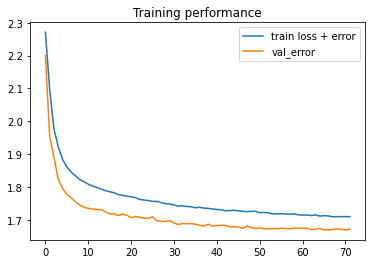

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

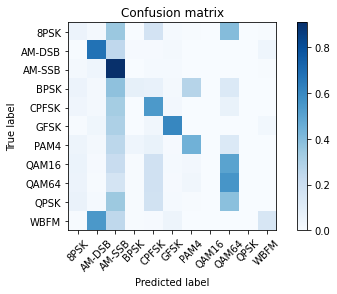

In [15]:
evaluationlib.plot_confusion_matrix(model, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08803863298662705
Overall Accuracy:  0.09500924214417746


Overall Accuracy:  0.09473312124425592


Overall Accuracy:  0.10576247364722417


Overall Accuracy:  0.13186416184971098


Overall Accuracy:  0.19011815252416756


Overall Accuracy:  0.24220709423145825


Overall Accuracy:  0.34665697674418605


Overall Accuracy:  0.4327298544550941
Overall Accuracy:  0.4805895039539899


Overall Accuracy:  0.477124183006536
Overall Accuracy:  0.5095564370717635


Overall Accuracy:  0.5070208728652752
Overall Accuracy:  0.5123134328358209


Overall Accuracy:  0.49747838616714696
Overall Accuracy:  0.5063798760481225


Overall Accuracy:  0.5198074787115883
Overall Accuracy:  0.5125987213238059


Overall Accuracy:  0.5169491525423728
Overall Accuracy:  0.5283154121863799


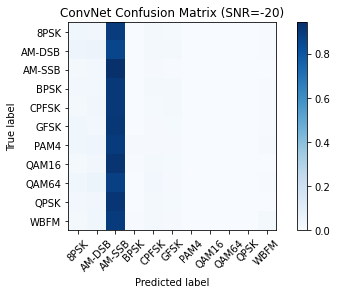

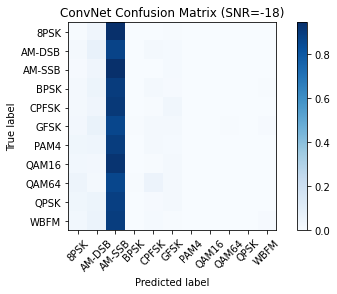

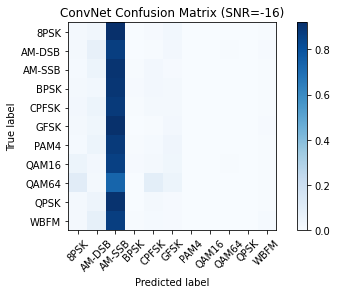

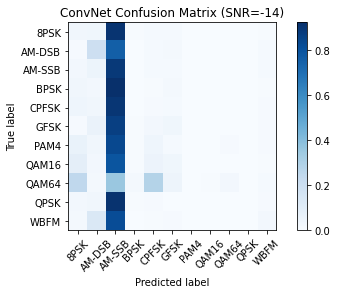

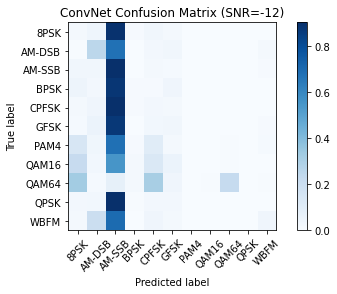

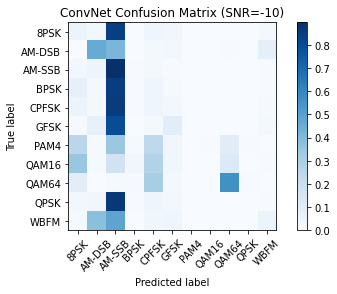

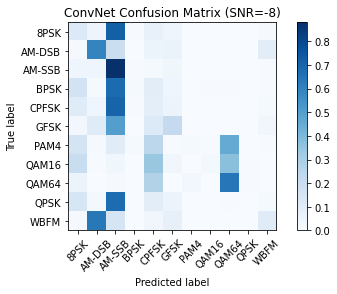

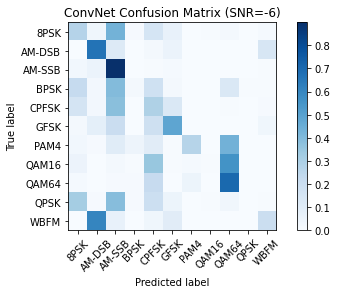

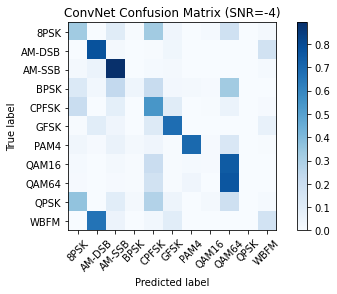

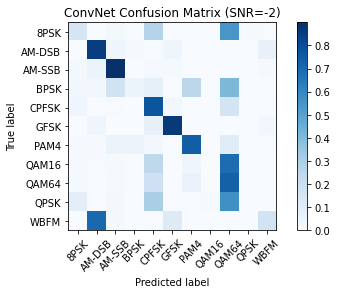

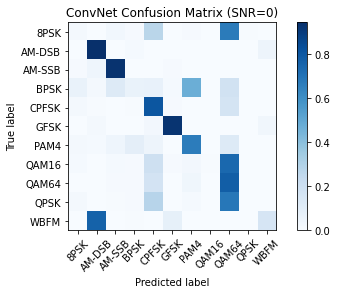

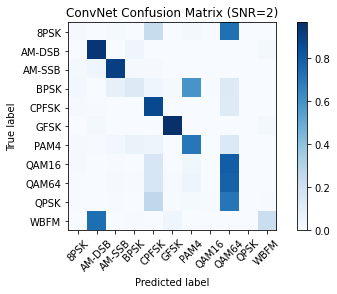

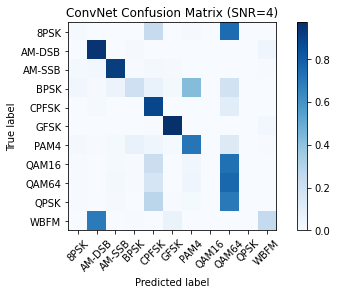

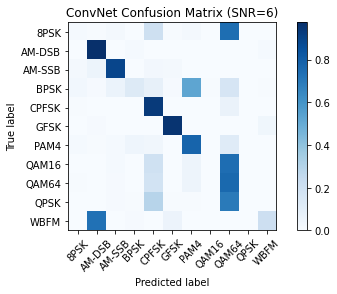

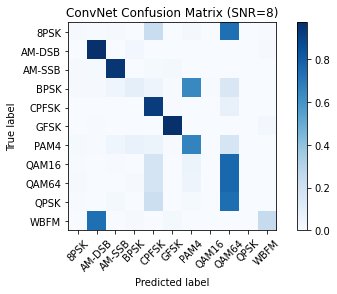

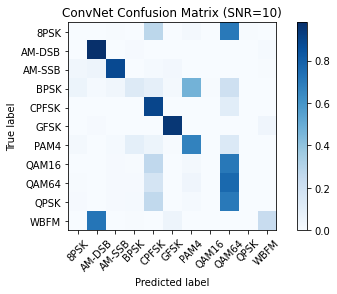

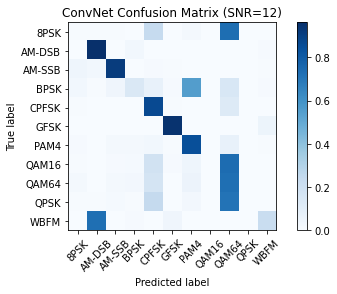

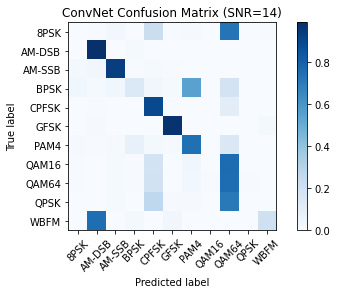

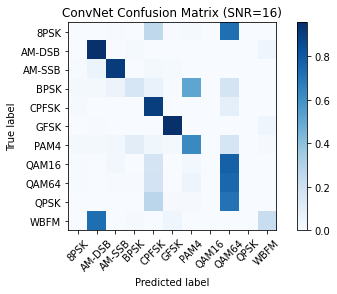

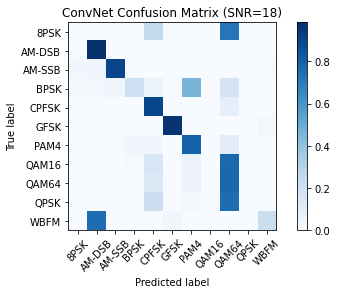

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,10,13,19,24,34,43,48,47,50,50,51,49,50,51,51,51,52


In [18]:
# Save results to a pickle file for plotting later
# fd = open(OUTPUT_FILENAME,'wb')
# pickle.dump( ("CNN2", 0.5, acc) , fd )

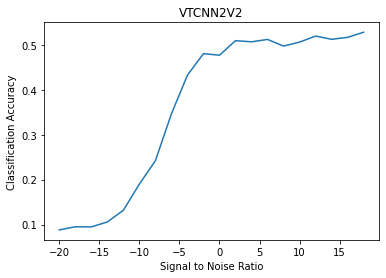

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)